# **物件偵測專班**

# YOLOv4 手把手訓練教學

## 匯入所需套件

In [ ]:
!pip install wandb pycocotools PyYAML==5.4.1 opencv-python==4.4.0.46 imgaug==0.2.5 -q

     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 636 kB 44.2 MB/s 
     |████████████████████████████████| 49.5 MB 196 kB/s 
     |████████████████████████████████| 562 kB 37.4 MB/s 
     |████████████████████████████████| 144 kB 37.9 MB/s 
     |████████████████████████████████| 181 kB 12.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [1]:
!git clone https://github.com/d246810g2000/PyTorch_YOLOv4.git

Cloning into 'PyTorch_YOLOv4'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 813 (delta 66), reused 128 (delta 37), pack-reused 648
Receiving objects: 100% (813/813), 32.93 MiB | 29.61 MiB/s, done.
Resolving deltas: 100% (419/419), done.


In [4]:
%cd /content/PyTorch_YOLOv4/

/content/PyTorch_YOLOv4


In [ ]:
import os
import cv2
import math
import yaml
import wandb
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from utils.torch_utils import ModelEMA

import test
from models.models import *
from utils.general import labels_to_class_weights, fitness, strip_optimizer, check_img_size, bbox_iou
from utils.plots import plot_images, plot_labels, plot_lr_scheduler
from utils.datasets import get_hash, exif_size, load_image, load_mosaic, letterbox, random_perspective, augment_hsv

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline  

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## [貓狗公開資料集](https://public.roboflow.com/object-detection/oxford-pets/2/images/fc82071578629d4d44696cb666898d45)
<img src="https://github.com/d246810g2000/PyTorch_YOLOv4/blob/master/slide_image/data_preview.png?raw=true" width=1080/>

這個貓狗公開資料集提供了 3680 張影像，為了訓練快一點，這邊只取了 250 張影像來訓練，檔案放在 datasets/pet.zip 中，先用 convert_voc_to_yolo.py 將 PascalVOC 轉換成 YOLO 格式：

In [5]:
!unzip -q datasets/datasets.zip -d datasets/
!python convert_voc_to_yolo.py

轉換後的資料集結構如下：
- 訓練集: 200 張
- 驗證集: 50 張

```  
train
│
└───images (訓練用影像: 200) 
│   │   Abyssinian_105.jpg
│   │   Abyssinian_169.jpg
│   │   ...
│
└───labels (標記檔案: 200)
    │   Abyssinian_105.txt
    │   Abyssinian_169.txt
    │   ...
    
valid
│
└───images (驗證用影像: 50) 
│   │   Abyssinian_170.jpg
│   │   Birman_101.jpg
│   │   ...
│   
└───labels (標記檔案: 50)
    │   Abyssinian_170.txt
    │   Birman_101.txt
    │   ...
```

創建 pet.yaml 裡面需要記錄：
1. train: datasets/pet/train/images # 訓練集路徑
2. val: datasets/pet/valid/images # 驗證集路徑
3. nc: 2 # 類別數量
4. names  [cat, dog] #類別名稱

In [ ]:
!echo -e 'train: datasets/pet/train/images\nval: datasets/pet/valid/images\n\nnc: 2\nnames: [cat, dog]' > data/pet.yaml
!head data/pet.yaml

train: datasets/pet/train/images
val: datasets/pet/valid/images

nc: 2
names: [cat, dog]


## 使用 wandb 記錄訓練過程
- 先進入官網登入：https://wandb.ai/site 
- 右上方頭像 -> settings -> 複製 API keys -> 填入下方輸入處

In [ ]:
# Logging
id = wandb.util.generate_id()
wandb_run = wandb.init(project='YOLOv4', name=id, id=id)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 參數設置

In [ ]:
# Parameters
project = 'runs/train'
name = id
data = 'data/pet.yaml' 
cfg = 'cfg/yolov4-pet.cfg'
weights = 'yolov4.weights'
hyp = 'data/hyp.scratch.yaml'
img_size = [416, 416]
batch_size = 4
epochs = 300
workers = 8

'''
nbs 為模擬的 batch_size; 
例如上面設置的 batch_size 為 4, nbs 為 16
等於模型梯度累積了 16/4=4 (accumulate) 次之後
再更新一次模型，變相的擴大了 batch_size
'''
nbs = 16  # nominal batch size
accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing

# Hyperparameters
# 讀取 hyp 參數
with open(hyp) as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)  # load hyps

# 設置保存 results 的路徑
save_dir = Path(project) / name 
save_dir.mkdir(parents=True, exist_ok=True)  # make dir
results_file = save_dir / 'results.txt'

# 保存 hyp 參數到自己的路徑下
with open(save_dir / 'hyp.yaml', 'w') as f:
    yaml.dump(hyp, f, sort_keys=False)

# 設置資料集路徑
with open(data) as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader)  
train_path = data_dict['train']
test_path = data_dict['val']

# 獲取類別數量和類別名字
nc = int(data_dict['nc'])
names = data_dict['names'] 

# Configure
# 是否繪製訓練、測試圖片、指標圖等
plots = True  

## 訓練總覽
1. 資料前處理：讀取影像、資料增強
2. 建立 YOLOv4 模型：CSPDarknet53+SPP+PANet
3. 損失函數計算：正樣本匹配策略和 loss 函數定義
4. 優化器定義和學習率策略：Cosine annealing scheduler
5. 開始訓練：將訓練過程記錄到 wandb 裡面

### 1. 資料前處理：讀取影像、資料增強



In [ ]:
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes

class LoadImagesAndLabels(torch.utils.data.Dataset):  # for training/testing
    def __init__(self, path, img_size=640, batch_size=16, augment=False, mosaic=False, hyp=None, stride=32, pad=0.0):
        self.img_size = img_size
        self.augment = augment
        self.hyp = hyp
        self.mosaic = mosaic  # load 4 images at a time into a mosaic (only during training)
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.stride = stride

        def img2label_paths(img_paths):
            # Define label paths as a function of image paths
            sa, sb = os.sep + 'images' + os.sep, os.sep + 'labels' + os.sep  # /images/, /labels/ substrings
            return [x.replace(sa, sb, 1).replace(x.split('.')[-1], 'txt') for x in img_paths]
        
        # 得到 path 路徑下的所有圖片路徑 self.img_files
        try:
            f = []  # image files
            for p in path if isinstance(path, list) else [path]:
                p = Path(p)  # os-agnostic
                if p.is_dir():  # dir
                    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
                elif p.is_file():  # file
                    with open(p, 'r') as t:
                        t = t.read().splitlines()
                        parent = str(p.parent) + os.sep
                        f += [x.replace('./', parent) if x.startswith('./') else x for x in t]  # local to global path
                else:
                    raise Exception('%s does not exist' % p)
            self.img_files = sorted([x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in img_formats])
            assert self.img_files, 'No images found'
        except Exception as e:
            raise Exception('Error loading data from %s: %s' % (path, e))

        # 根據 imgs 路徑找到 labels 的路徑: self.label_files
        self.label_files = img2label_paths(self.img_files)  # labels
        # Check cache
        # 下次運行時直接從 cache 中取出 label，速度會更快
        cache_path = str(Path(self.label_files[0]).parent) + '.cache3'  # cached labels
        if os.path.isfile(cache_path):
            cache = torch.load(cache_path)  # load
            # 如果文件 hash 值對不上，說明資料集的圖片和標籤可能發生了變化，那就重新 cache label 文件
            if cache['hash'] != get_hash(self.label_files + self.img_files):  # dataset changed
                cache = self.cache_labels(cache_path)  # re-cache
        else:
            cache = self.cache_labels(cache_path)  # cache

        # Read cache
        cache.pop('hash')  # remove hash
        labels, shapes = zip(*cache.values())
        self.labels = list(labels)
        self.shapes = np.array(shapes, dtype=np.float64)
        self.img_files = list(cache.keys())  # update
        self.label_files = img2label_paths(cache.keys())  # update

        n = len(shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(np.int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.imgs = [None] * n

    def cache_labels(self, path='labels.cache3'):
        # Cache dataset labels, check images and read shapes
        x = {}  # dict
        pbar = tqdm(zip(self.img_files, self.label_files), desc='Scanning images', total=len(self.img_files))
        for (img, label) in pbar:
            try:
                l = []
                im = Image.open(img)
                im.verify()  # PIL verify
                shape = exif_size(im)  # image size
                assert (shape[0] > 9) & (shape[1] > 9), 'image size <10 pixels'
                if os.path.isfile(label):
                    with open(label, 'r') as f:
                        l = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)  # labels
                if len(l) == 0:
                    l = np.zeros((0, 5), dtype=np.float32)
                x[img] = [l, shape]
            except Exception as e:
                print('WARNING: Ignoring corrupted image and/or label %s: %s' % (img, e))

        x['hash'] = get_hash(self.label_files + self.img_files)
        torch.save(x, path)  # save for next time
        return x

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        '''
        訓練 資料增強: mosaic(random_perspective) + hsv + 上下左右翻轉
        測試 資料增強: letterbox
        :return torch.from_numpy(img): 這個 index 的圖片數據(增強後) [3, 640, 640]
        :return labels_out: 這個 index 圖片的 gt label [6, 6] = [gt_num, 0+class+xywh(normalized)]
        :return self.img_files[index]: 這個 index 圖片的路徑地址
        :return shapes: 這個 batch 的圖片的 shapes 
        '''
        hyp = self.hyp # 裡面包含許多資料增強的超參數
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        if mosaic:
            # Load mosaic
            img, labels = load_mosaic(self, index)
            shapes = None

        else:
            # Load image
            # 載入圖片並進行 resize 將當前圖片的最長邊縮放到指定的大小 (img_size=640)，較小邊同比例縮放
            # 這一步是將 (350, 480, 3) resize-> (467, 640, 3)
            # img: resize 後的圖片, (h0, w0): 原始圖片的hw, (h, w): resize 後圖片的 hw
            img, (h0, w0), (h, w) = load_image(self, index)

            # Letterbox
            # letterbox 這一步將第一步縮放得到的圖片再縮放到當前 batch 所需要的尺度 
            # (467, 640, 3) + pad=(0.0, 13.5) -> (480, 640, 3)
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            # Load labels
            # 圖片 letterbox 之後 label 的座標也要相應變化，根據 pad 調整 label 座標，並將歸一化的 xywh -> 未歸一化的 xyxy
            labels = []
            x = self.labels[index]
            if x.size > 0:
                # Normalized xywh to pixel xyxy format
                labels = x.copy()
                labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]  # pad width
                labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]  # pad height
                labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
                labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]

        if self.augment:
            # Augment imagespace
            if not mosaic:
                # 不做 mosaic 的話就要做 random_perspective 增強 因為 mosaic 函數內部執行了 random_perspective 增強
                # random_perspective 增強: 隨機對圖片進行旋轉、平移、縮放、裁剪、透視變換
                img, labels = random_perspective(img, labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])

            # Augment colorspace
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

        nL = len(labels)  # number of labels
        if nL:
            labels[:, 1:5] = xyxy2xywh(labels[:, 1:5])  # convert xyxy to xywh
            labels[:, [2, 4]] /= img.shape[0]  # normalized height 0-1
            labels[:, [1, 3]] /= img.shape[1]  # normalized width 0-1
            
        # 平移增強：隨機左右翻轉 + 隨機上下翻轉
        if self.augment:
            # flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nL:
                    labels[:, 2] = 1 - labels[:, 2]

            # flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nL:
                    labels[:, 1] = 1 - labels[:, 1]

        labels_out = torch.zeros((nL, 6))
        if nL:
            labels_out[:, 1:] = torch.from_numpy(labels)

        # Convert
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)

        return torch.from_numpy(img), labels_out, self.img_files[index], shapes

    @staticmethod
    def collate_fn(batch):
        # 這邊將 batch 的 img 和 label 拼接起來，而這裡之所以拼接的方式不同 (stack or cat) 
        # 是因為 img 拼接的時候它的每個部分的形狀是相同的
        # 而 label 的每個部分的形狀不一定是相同的，因為每張圖的目標個數不一定相同
        img, label, path, shapes = zip(*batch)  # transposed
        for i, l in enumerate(label):
            l[:, 0] = i  # add target image index for build_targets()
        return torch.stack(img, 0), torch.cat(label, 0), path, shapes

In [ ]:
def create_dataloader(path, imgsz, batch_size, stride, hyp=None, augment=False, mosaic=False, shuffle=False, pad=0.0, world_size=1, workers=8):
    dataset = LoadImagesAndLabels(path, imgsz, batch_size,
                                  augment=augment,  # augment images
                                  mosaic=mosaic,
                                  hyp=hyp,  # augmentation hyperparameters
                                  stride=int(stride),
                                  pad=pad)

    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count() // world_size, batch_size if batch_size > 1 else 0, workers])  # number of workers
    dataloader = torch.utils.data.DataLoader(dataset, 
                                             batch_size=batch_size, 
                                             shuffle=shuffle,
                                             num_workers=nw,
                                             collate_fn=LoadImagesAndLabels.collate_fn)
    return dataloader, dataset

In [ ]:
# Image sizes
# 獲取模型總步長和模型輸入圖片分辨率
gs = 32 # grid size (max stride)
# 檢查輸入圖片分辨率確保能夠整除總步長gs
imgsz, imgsz_test = [check_img_size(x, gs) for x in img_size]  # verify imgsz are gs-multiples

# Trainloader
dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, hyp=hyp, augment=True, mosaic=True, shuffle=True)
nb = len(dataloader)  # number of batches

# Testloader
testloader = create_dataloader(test_path, imgsz_test, batch_size*2, gs, hyp=hyp, shuffle=False)[0]  # testloader

Scanning images: 100%|██████████| 50/50 [00:00<00:00, 4451.32it/s]


看一下資料增強後的結果如何：

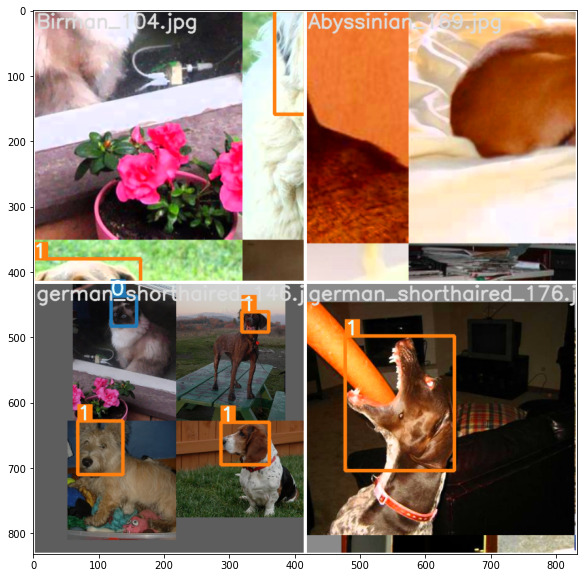

In [ ]:
imgs, labels, paths, _ = next(iter(dataloader))
train_batch = plot_images(images=imgs, targets=labels, paths=paths, fname='train_batch_sample.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(train_batch)

### 2. 建立 YOLOv4 模型：CSPDarknet53+SPP+PANet
<img src="https://github.com/d246810g2000/PyTorch_YOLOv4/blob/master/slide_image/yolov4_model.png?raw=true" width=1080/>

需先更改 cfg 中類別和對應 filter 的部份

In [ ]:
!cp cfg/yolov4.cfg cfg/yolov4-pet.cfg

In [ ]:
!sed -n -e 959p -e 966p -e 1046p -e 1053p -e 1133p -e 1140p cfg/yolov4-pet.cfg

filters=255
classes=80
filters=255
classes=80
filters=255
classes=80


In [ ]:
!sed -i '959s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '966s/80/2/' cfg/yolov4-pet.cfg
!sed -i '1046s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '1053s/80/2/' cfg/yolov4-pet.cfg
!sed -i '1133s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '1140s/80/2/' cfg/yolov4-pet.cfg

In [ ]:
!sed -n -e 959p -e 966p -e 1046p -e 1053p -e 1133p -e 1140p cfg/yolov4-pet.cfg

filters=21
classes=2
filters=21
classes=2
filters=21
classes=2


In [ ]:
# Model
model = Darknet(cfg).to(device) # create

# 下載預訓練模型並加載到模型中
# !wget https://github.com/d246810g2000/PyTorch_YOLOv4/releases/download/v1.0/yolov4.weights
# load_darknet_weights(model, weights)

# Model parameters
hyp['cls'] *= nc / 80.  # scale coco-tuned hyp['cls'] to current dataset
model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.gr = 1.0  # iou loss ratio (obj_loss = 1.0 or iou)
model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
model.names = names

In [ ]:
# EMA
ema = ModelEMA(model)

### 3. 損失函數計算：正樣本匹配策略和 loss 函數定義

**正樣本匹配策略：從 label 建置符合條件的正樣本 target**

選取正樣本採用了跨網格匹配規則，增加正樣本 anchor 數量的做法：對於任何一個輸出層，直接採用 shape 規則匹配，也就是該 bbox 和當前層的 anchor 計算寬高比，如果寬高比例大於設定閾值，則說明該 bbox 和 anchor 匹配度不夠，將該 bbox 過濾暫時丟掉，在該層預測中認為是背景，除了中心的 grid 外還找出最近的兩個 grid，將這三個 grid 都認為是負責預測該 bbox 的 anchor。

<img src="https://github.com/d246810g2000/PyTorch_YOLOv4/blob/master/slide_image/target_grids.png?raw=true" width=720/>

In [ ]:
def build_targets(p, targets, model):
    """
    Build targets for compute_loss()
    :params p: 預測框 由模型構建中的三個 Detector 返回的三個 yolo 層的輸出
               如: [1, 3, 52, 52, 7]、[1, 3, 26, 26, 7]、[1, 3, 13, 13, 7]
               [bs, anchor_num, grid_h, grid_w, xywh+obj+classes]
    :params targets: 數據增強後的 label [1, 6] [num_target,  image_index+class+xywh] xywh 為正規化後的框
    :return tcls: 表示這個 target 所屬的 class index
            tbox: xywh 其中 xy 為這個 target 對當前 grid_cell 左上角的偏移量
            indices: b: 表示這個 target 屬於的 image index
                     a: 表示這個 target 使用的 anchor index
                    gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
                    gi: 表示這個網格的左上角 x 座標
            anch: 表示這個 target 所使用 anchor 的尺度（相對於這個feature map）
    """    
    nt = targets.shape[0]  # number of anchors, targets
    tcls, tbox, indices, anch = [], [], [], []
    # gain 是為了後面將 targets 中正規化的 xywh 映射到相對 feature map 尺度上
    gain = torch.ones(6, device=targets.device)  # normalized to gridspace gain
    # 以周圍 4 個網格來計算 offsets
    off = torch.tensor([[1, 0], [0, 1], [-1, 0], [0, -1]], device=targets.device).float()  # overlap offsets
    g = 0.5  # offset

    # 遍歷三個 feature 篩選每個 feature map 的每個 anchor 正樣本
    for i, jj in enumerate(model.yolo_layers):
        # get number of grid points and anchor vec for this yolo layer
        anchors = model.module_list[jj].anchor_vec
        gain[2:] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain

        # Match targets to anchors
        a, t, offsets = [], targets * gain, 0
        # 開始匹配
        if nt:
            na = anchors.shape[0]  # number of anchors
            at = torch.arange(na).view(na, 1).repeat(1, nt)  # anchor tensor, same as .repeat_interleave(nt)
            # anchor 與 label 的長寬比低於一定閾值就是正樣本
            r = t[None, :, 4:6] / anchors[:, None]  # wh ratio
            j = torch.max(r, 1. / r).max(2)[0] < model.hyp['anchor_t']  # compare
#             j = wh_iou(anchors, t[:, 4:6]) > model.hyp['iou_t']  
            # 根據篩選條件 j, 過濾負樣本, 得到當前 feature map 上三個 anchor 的所有 anchor index: a 與正樣本: t
            a, t = at[j], t.repeat(na, 1, 1)[j]  # filter

            # overlaps
            gxy = t[:, 2:4]  # grid xy
            z = torch.zeros_like(gxy)
            # 篩選中心座標 
            # 距離當前 grid_cell 的左、上方偏移小於 g=0.5 且 中心座標必須大於 1 (座標不能在邊上，此時就沒有4個格子了)
            # j: 如果是 True 表示當前 target 中心點所在的格子的左邊格子也對該 target 進行迴歸 (後續進行計算損失)
            # k: 如果是 True 表示當前 target 中心點所在的格子的上邊格子也對該 target 進行迴歸(後續進行計算損失)
            j, k = ((gxy % 1. < g) & (gxy > 1.)).T
            # 距離當前 grid_cell 的右、下方偏移小於 g=0.5 且 中心座標必須大於 1 (座標不能在邊上，此時就沒有4個格子了)
            # l: 如果是 True 表示當前 target 中心點所在的格子的右邊格子也對該 target 進行迴歸 (後續進行計算損失)
            # m: 如果是 True 表示當前 target 中心點所在的格子的下邊格子也對該 target 進行迴歸 (後續進行計算損失)
            l, m = ((gxy % 1. > (1 - g)) & (gxy < (gain[[2, 3]] - 1.))).T
            a, t = torch.cat((a, a[j], a[k], a[l], a[m]), 0), torch.cat((t, t[j], t[k], t[l], t[m]), 0)
            # 得到所有篩選後的網格的中心相對於這個要預測的 label 所在網格邊界（左右上下邊框）的偏移量
            offsets = torch.cat((z, z[j] + off[0], z[k] + off[1], z[l] + off[2], z[m] + off[3]), 0) * g

        # Define
        b, c = t[:, :2].long().T  # image index, class
        gxy = t[:, 2:4]  # grid xy
        gwh = t[:, 4:6]  # grid wh
        gij = (gxy - offsets).long()
        gi, gj = gij.T  # grid xy indices

        # Append
        #indices.append((b, a, gj, gi))  # image, anchor, grid indices
        indices.append((b, a, gj.clamp_(0, gain[3] - 1), gi.clamp_(0, gain[2] - 1)))  # image, anchor, grid indices
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
        anch.append(anchors[a])  # anchors
        tcls.append(c)  # class

    return tcls, tbox, indices, anch

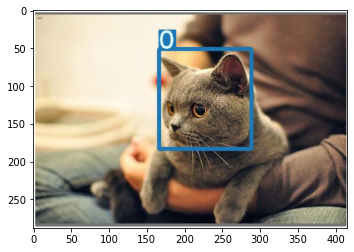

In [ ]:
img_path = 'demo/British_Shorthair_100.jpg'
label_path = 'demo/British_Shorthair_100.txt'
img0 = cv2.imread(img_path).astype('float32')
img_pad = letterbox(img0, new_shape=img_size, auto_size=32)[0]
img = img_pad[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
img = np.ascontiguousarray(img)
img = torch.from_numpy(img).to(device)
img /= 255.0
img = torch.unsqueeze(img, 0)
h, w = img.shape[-2:]
p = model(img)

with open(label_path, 'r') as f:
    label = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)  # labels
label = np.insert(label, 0, 0)
targets = torch.from_numpy(label).to(device)
targets = torch.unsqueeze(targets, 0)
vis_label = plot_images(img, targets)
plt.imshow(vis_label)

In [ ]:
targets

tensor([[0.00000, 0.00000, 0.54700, 0.40813, 0.29400, 0.46084]], device='cuda:0')

In [ ]:
tcls, tbox, indices, anchors = build_targets(p, targets, model)  # targets

tcls: 表示這個 target 所屬的 class index

In [ ]:
tcls

[tensor([], device='cuda:0', dtype=torch.int64),
 tensor([0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')]

tbox: xywh 其中 xy 為這個 target 對當前 grid_cell 左上角的偏移量

In [ ]:
tbox

[tensor([], device='cuda:0', size=(0, 4)),
 tensor([[0.22200, 0.34639, 7.64400, 8.29518],
         [0.22200, 0.34639, 7.64400, 8.29518],
         [1.22200, 0.34639, 7.64400, 8.29518],
         [1.22200, 0.34639, 7.64400, 8.29518],
         [0.22200, 1.34639, 7.64400, 8.29518],
         [0.22200, 1.34639, 7.64400, 8.29518]], device='cuda:0'),
 tensor([[ 0.11100,  0.67319,  3.82200,  4.14759],
         [ 0.11100,  0.67319,  3.82200,  4.14759],
         [ 0.11100,  0.67319,  3.82200,  4.14759],
         [ 1.11100,  0.67319,  3.82200,  4.14759],
         [ 1.11100,  0.67319,  3.82200,  4.14759],
         [ 1.11100,  0.67319,  3.82200,  4.14759],
         [ 0.11100, -0.32681,  3.82200,  4.14759],
         [ 0.11100, -0.32681,  3.82200,  4.14759],
         [ 0.11100, -0.32681,  3.82200,  4.14759]], device='cuda:0')]

anchors: 表示這個 target 所使用 anchor 的尺度（相對於這個feature map）

In [ ]:
anchors

[tensor([], device='cuda:0', size=(0, 2)), tensor([[3.87500, 2.81250],
         [3.68750, 7.43750],
         [3.87500, 2.81250],
         [3.68750, 7.43750],
         [3.87500, 2.81250],
         [3.68750, 7.43750]], device='cuda:0'), tensor([[ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750],
         [ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750],
         [ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750]], device='cuda:0')]

In [ ]:
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]])
anch_masks = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
strides = np.array([8, 16, 32])
anchor_vec = []
for i in range(3):
    anc = []
    for j in range(3):
        anc.append(anchors[anch_masks[i][j]]/strides[i])
    anchor_vec.append(anc)
anchor_vec

[[array([       1.25,       1.625]),
  array([          2,        3.75]),
  array([      4.125,       2.875])],
 [array([      1.875,      3.8125]),
  array([      3.875,      2.8125]),
  array([     3.6875,      7.4375])],
 [array([      3.625,      2.8125]),
  array([      4.875,      6.1875]),
  array([     11.656,      10.188])]]

indices:
- b: 表示這個 target 屬於的 image index
- a: 表示這個 target 使用的 anchor index
- gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
- gi: 表示這個網格的左上角 x 座標

In [ ]:
indices

[(tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 (tensor([0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([1, 2, 1, 2, 1, 2]),
  tensor([7, 7, 7, 7, 6, 6], device='cuda:0'),
  tensor([14, 14, 13, 13, 14, 14], device='cuda:0')),
 (tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]),
  tensor([3, 3, 3, 3, 3, 3, 4, 4, 4], device='cuda:0'),
  tensor([7, 7, 7, 6, 6, 6, 7, 7, 7], device='cuda:0'))]

解說三層 yolo layer 分別輸出的 target 

In [ ]:
x, y = label[2:4]
x_, y_ = x*w, y*h

1. stride=8: 偵測小物體，anchor: [10, 13], [16, 30], [33, 23]

In [ ]:
grid = (w/8, h/8)
grid

(52.0, 36.0)

In [ ]:
# indices: b: 表示這個 target 屬於的 image index
#          a: 表示這個 target 使用的 anchor index
#         gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
#         gi: 表示這個網格的左上角 x 座標
indices[0]

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

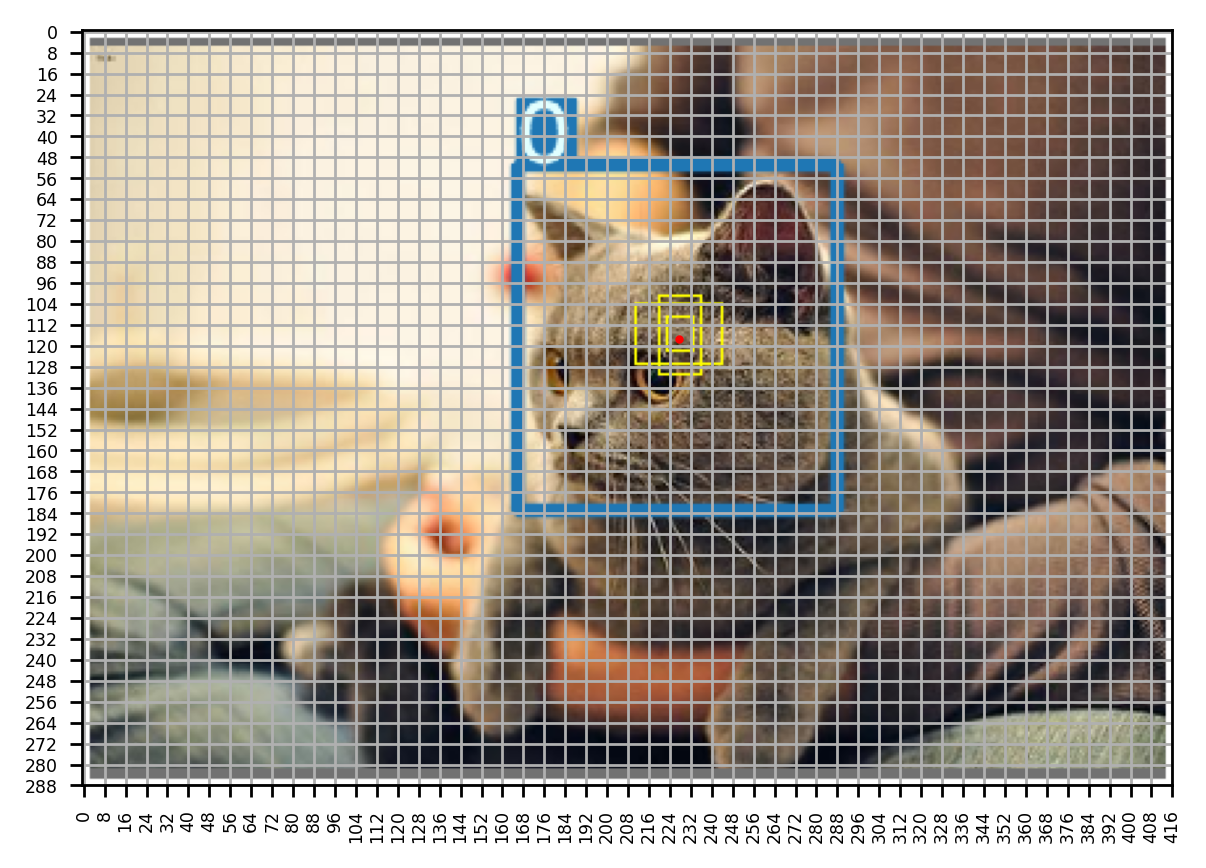

In [ ]:
anchor_1 = [[10, 13], [16, 30], [33, 23]]
anc_xy_1 = []
for anc_w, anc_h in anchor_1:
    anc_x1y1 = (int(28*8+4-anc_w/2), int(14*8+4-anc_h/2))
    anc_x2y2 = (int(28*8+4+anc_w/2), int(14*8+4+anc_h/2))
    anc_xy_1.append((anc_x1y1, anc_x2y2))

fig, ax = plt.subplots()
fig.set_dpi(250)
vis_label = plot_images(img, targets)
for anc in anc_xy_1: 
    cv2.rectangle(vis_label, anc[0], anc[1], [255, 255, 0], 1)
ax.imshow(vis_label)
ax.scatter(x_, y_, c='red', s=2)
ax.set_xticks(8*(np.arange(grid[0]+1)))
ax.set_yticks(8*(np.arange(grid[1]+1)))
ax.grid()
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
ax.tick_params(axis='y', labelsize=5)

2. stride=16: 偵測中物體，anchor: [30, 61], [62, 45], [59, 119]

In [ ]:
grid = (w/16, h/16)
grid

(26.0, 18.0)

In [ ]:
# indices: b: 表示這個 target 屬於的 image index
#          a: 表示這個 target 使用的 anchor index
#         gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
#         gi: 表示這個網格的左上角 x 座標
indices[1]

(tensor([0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 2, 1, 2, 1, 2]),
 tensor([7, 7, 7, 7, 6, 6], device='cuda:0'),
 tensor([14, 14, 13, 13, 14, 14], device='cuda:0'))

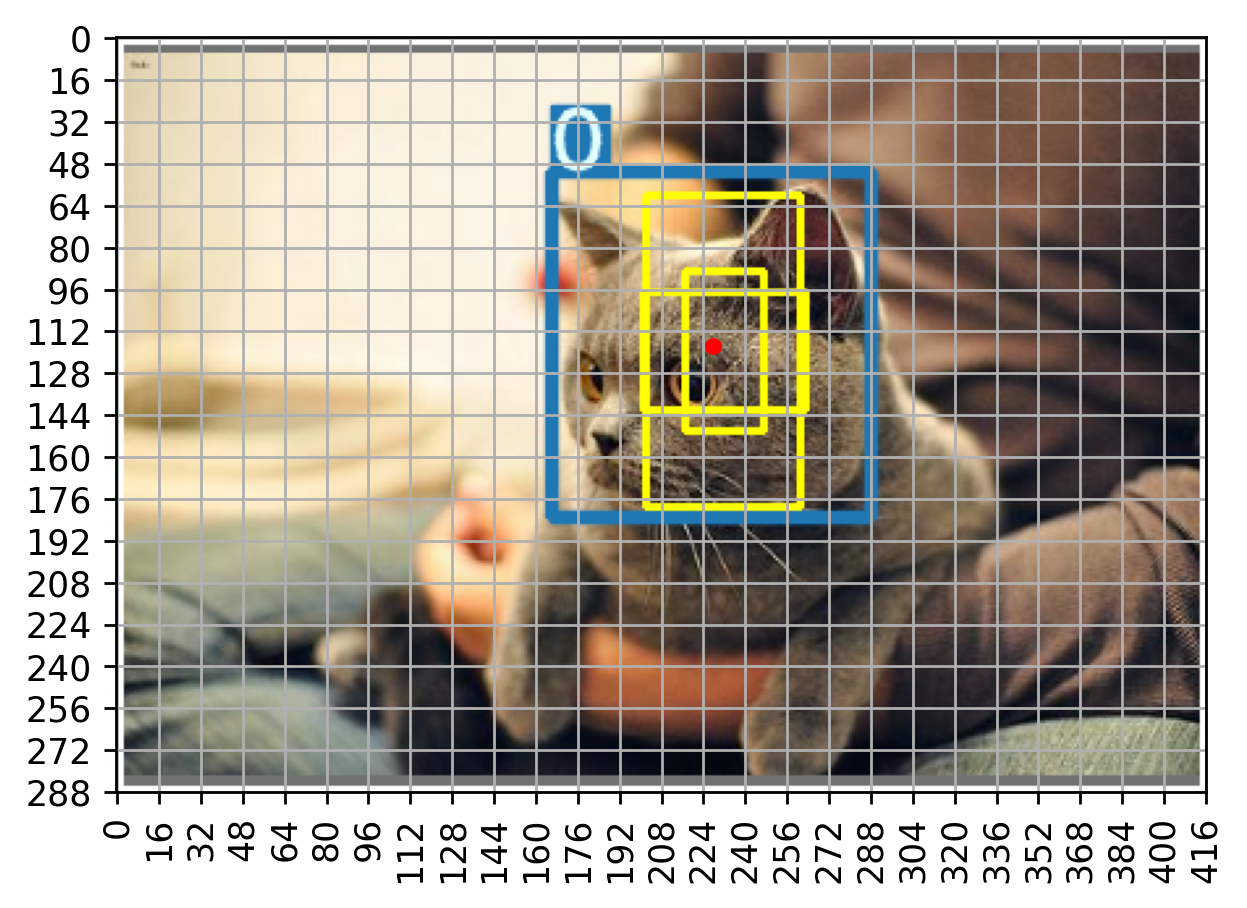

In [ ]:
anchor_2 = [[30, 61], [62, 45], [59, 119]]
anc_xy_2 = []
for anc_w, anc_h in anchor_2:
    anc_x1y1 = (int(14*16+8-anc_w/2), int(7*16+8-anc_h/2))
    anc_x2y2 = (int(14*16+8+anc_w/2), int(7*16+8+anc_h/2))
    anc_xy_2.append((anc_x1y1, anc_x2y2))

fig, ax = plt.subplots()
fig.set_dpi(250)
vis_label = plot_images(img, targets)
for anc in anc_xy_2: 
    cv2.rectangle(vis_label, anc[0], anc[1], [255, 255, 0], 2)
ax.imshow(vis_label)
ax.scatter(x_, y_, c='red', s=15)
ax.set_xticks(16*(np.arange(grid[0]+1)))
ax.set_yticks(16*(np.arange(grid[1]+1)))
ax.grid()
ax.tick_params(axis='x', labelrotation=90)

3. stride=32: 偵測大物體，anchor: [116, 90], [156, 198], [373, 326]

In [ ]:
grid = (w/32, h/32)
grid

(13.0, 9.0)

In [ ]:
# indices: b: 表示這個 target 屬於的 image index
#          a: 表示這個 target 使用的 anchor index
#         gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
#         gi: 表示這個網格的左上角 x 座標
indices[2]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]),
 tensor([3, 3, 3, 3, 3, 3, 4, 4, 4], device='cuda:0'),
 tensor([7, 7, 7, 6, 6, 6, 7, 7, 7], device='cuda:0'))

這邊我們把對應的所有正樣本都畫出來給各位看

In [ ]:
anchor_3 = [[116, 90], [156, 198], [373, 326]]
anc_xy_3 = []
for anc_w, anc_h in anchor_3:
    anc_x1y1 = (int(7*32+16-anc_w/2), int(3*32+16-anc_h/2))
    anc_x2y2 = (int(7*32+16+anc_w/2), int(3*32+16+anc_h/2))
    anc_xy_3.append((anc_x1y1, anc_x2y2))
    
for anc_w, anc_h in anchor_3:
    anc_x1y1 = (int(6*32+16-anc_w/2), int(3*32+16-anc_h/2))
    anc_x2y2 = (int(6*32+16+anc_w/2), int(3*32+16+anc_h/2))
    anc_xy_3.append((anc_x1y1, anc_x2y2))
    
for anc_w, anc_h in anchor_3:
    anc_x1y1 = (int(7*32+16-anc_w/2), int(4*32+16-anc_h/2))
    anc_x2y2 = (int(7*32+16+anc_w/2), int(4*32+16+anc_h/2))
    anc_xy_3.append((anc_x1y1, anc_x2y2))

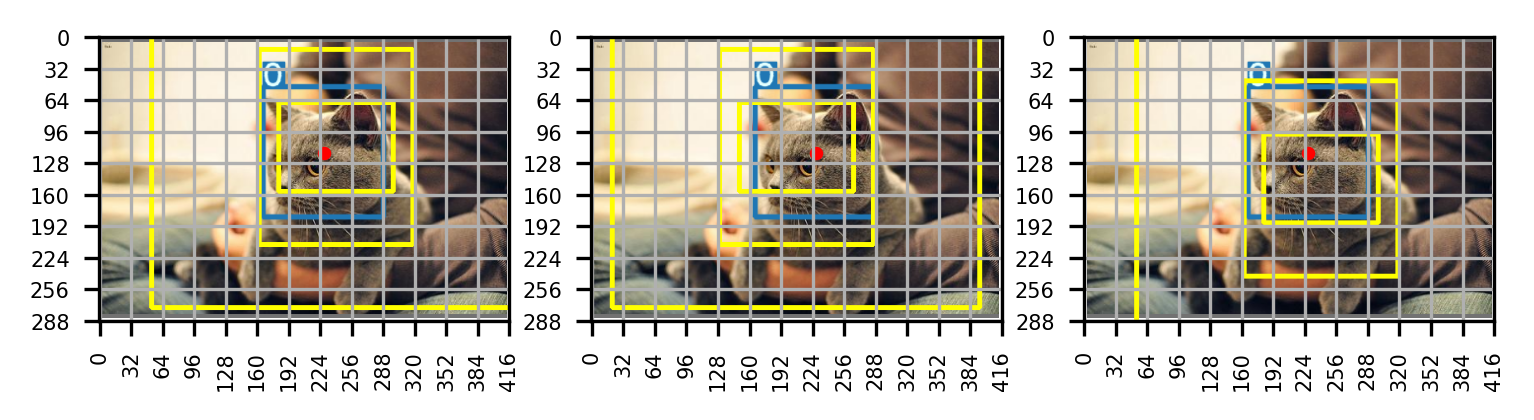

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_dpi(300)
for i in range(3):
    vis_label = plot_images(img, targets)
    for anc in anc_xy_3[3*i:3*(i+1)]: 
        cv2.rectangle(vis_label, anc[0], anc[1], [255, 255, 0], 3)
    ax[i].imshow(vis_label)
    ax[i].scatter(x_, y_, c='red', s=5)
    ax[i].set_xticks(32*(np.arange(grid[0]+1)))
    ax[i].set_yticks(32*(np.arange(grid[1]+1)))
    ax[i].grid()
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=5)
    ax[i].tick_params(axis='y', labelsize=5)

loss 函數定義

In [ ]:
from utils.loss import smooth_BCE
def compute_loss(p, targets, model):  # predictions, targets, model
    device = targets.device
    
    # 初始化 lcls, lbox, lobj 三種損失值 tensor([0.])
    lcls, lbox, lobj = torch.zeros(1, device=device), torch.zeros(1, device=device), torch.zeros(1, device=device)
    tcls, tbox, indices, anchors = build_targets(p, targets, model)  # targets
    h = model.hyp  # hyperparameters

    # Define criteria
    BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([h['cls_pw']])).to(device)
    BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([h['obj_pw']])).to(device)

    # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
    cp, cn = smooth_BCE(eps=0.0)

    # Losses
    nt = 0  # number of targets
    no = len(p)  # number of outputs
    
    # balance 用來設置三個 feature map 對應輸出的置信度損失係數 (平衡三個 feature map 的置信度損失)
    # 從左到右分別對應大 feature map (偵測小目標) 到小 feature map (偵測大目標)
    # 思路：一般來說，偵測小物體的難度大一點，所以會增加大特徵圖的損失係數，讓模型更加側重小物體的偵測
    balance = [4.0, 1.0, 0.4] if no == 3 else [4.0, 1.0, 0.4, 0.1]  # P3-5 or P3-6
    balance = [4.0, 1.0, 0.5, 0.4, 0.1] if no == 5 else balance
    for i, pi in enumerate(p):  # layer index, layer predictions
        b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
        tobj = torch.zeros_like(pi[..., 0], device=device)  # target obj

        n = b.shape[0]  # number of targets
        if n:
            nt += n  # cumulative targets
            ps = pi[b, a, gj, gi]  # prediction subset corresponding to targets

            # Regression
            pxy = ps[:, :2].sigmoid() * 2. - 0.5
            pwh = (ps[:, 2:4].sigmoid() * 2) ** 2 * anchors[i]
            pbox = torch.cat((pxy, pwh), 1).to(device)  # predicted box
            iou = bbox_iou(pbox.T, tbox[i], x1y1x2y2=False, CIoU=True)  # iou(prediction, target)
            lbox += (1.0 - iou).mean()  # iou loss

            # Objectness
            tobj[b, a, gj, gi] = (1.0 - model.gr) + model.gr * iou.detach().clamp(0).type(tobj.dtype)  # iou ratio

            # Classification
            if model.nc > 1:  # cls loss (only if multiple classes)
                t = torch.full_like(ps[:, 5:], cn, device=device)  # targets
                t[range(n), tcls[i]] = cp
                lcls += BCEcls(ps[:, 5:], t)  # BCE

        lobj += BCEobj(pi[..., 4], tobj) * balance[i]  # obj loss

    s = 3 / no  # output count scaling
    lbox *= h['box'] * s
    lobj *= h['obj'] * s * (1.4 if no >= 4 else 1.)
    lcls *= h['cls'] * s
    bs = tobj.shape[0]  # batch size

    loss = lbox + lobj + lcls
    return loss * bs, torch.cat((lbox, lobj, lcls, loss)).detach()

### 4. 優化器定義和學習率策略

SGD+WarmUP_CosineAnnealingLR

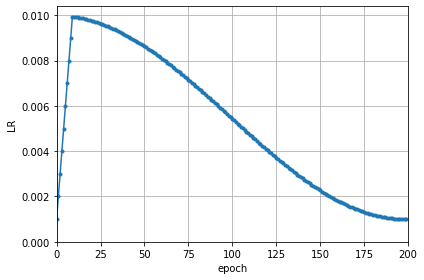

In [ ]:
optimizer = optim.SGD(model.parameters(), 
                      lr=hyp['lr0'],
                      momentum=hyp['momentum'],
                      nesterov=True)  

warm_up_iter = epochs//20
lf = lambda x: x / warm_up_iter if x < warm_up_iter else \
    ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - hyp['lrf']) + hyp['lrf']

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
plot_lr_scheduler(optimizer, scheduler, epochs)

### 5. 開始訓練
Colab 會隨機分配會隨機分配 K80 和 T4 給免費用戶，算力有差別：
- K80 大概需要訓練四個小時
- T4 大概需要訓練一個半小時

In [ ]:
!nvidia-smi

Sat Mar 12 09:23:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    56W / 149W |   1756MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

     epoch   memeory  box_loss  obj_loss  cls_loss  total_loss   targets  img_size


     1/300     10.3G     0.114   0.02893   0.01724      0.1602         8       448: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
     2/300     10.3G    0.1106   0.02982   0.01731      0.1577        11       448: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
     3/300     10.3G    0.1034   0.03276   0.01652      0.1527        11       416: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
     4/300     10.3G    0.1004   0.03224   0.01624      0.1489         7       448: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
     5/300     10.3G   0.09129   0.03147    0.0157      0.1385        10       448: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


                 all          50          50     0.00183       0.577     0.00216    0.000437


     6/300     10.3G    0.0912   0.03393   0.01543      0.1406         9       480: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
     7/300     10.3G   0.09019   0.03279   0.01515      0.1381        10       416: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
     8/300     10.3G    0.0874   0.03685   0.01516      0.1394        10       480: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
     9/300     10.3G   0.08933   0.03474    0.0153      0.1394        16       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
    10/300     10.3G   0.08805   0.03532   0.01518      0.1386        12       416: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


                 all          50           0           0           0           0           0


    11/300     10.3G   0.08567    0.0348   0.01468      0.1352        13       416: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
    12/300     10.3G   0.08739   0.03478    0.0144      0.1366         7       384: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
    13/300     10.3G   0.08378   0.03911   0.01504      0.1379        10       448: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
    14/300     10.3G   0.08714   0.03775   0.01487      0.1398        11       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    15/300     10.3G   0.08348   0.03905   0.01483      0.1374        12       416: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


                 all          50          50           0           0     0.00282    0.000321


    16/300     10.3G   0.08451    0.0382    0.0143       0.137        13       320: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]
    17/300     10.3G   0.08408   0.03779   0.01459      0.1365        11       320: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
    18/300     10.3G   0.08306   0.03798   0.01485      0.1359         7       320: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
    19/300     10.3G   0.08569   0.03605   0.01479      0.1365         5       448: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
    20/300     10.3G   0.08635   0.03406   0.01479      0.1352         7       352: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


                 all          50          50           0           0     0.00257    0.000631


    21/300     10.3G   0.08127   0.03338    0.0145      0.1291        12       384: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
    22/300     10.3G   0.08196   0.03867    0.0148      0.1354         9       352: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
    23/300     10.3G   0.08593   0.03697    0.0142      0.1371        13       384: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
    24/300     10.3G   0.08503   0.03658   0.01491      0.1365         9       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    25/300     10.3G   0.08471   0.03616   0.01471      0.1356        11       416: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50           0           0     0.00559     0.00142


    26/300     10.3G   0.08271   0.03878    0.0154      0.1369         5       512: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
    27/300     10.3G   0.08176   0.03693   0.01539      0.1341         6       352: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
    28/300     10.3G   0.08173   0.03295   0.01501      0.1297        10       448: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
    29/300     10.3G   0.08153   0.03538   0.01441      0.1313         9       448: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
    30/300     10.3G   0.08471   0.03659   0.01477      0.1361         6       352: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


                 all          50          50           0           0     0.00552     0.00144


    31/300     10.3G   0.08485   0.03566   0.01457      0.1351         7       448: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    32/300     10.3G   0.07903   0.03657   0.01465      0.1303         7       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
    33/300     10.3G   0.08317   0.03532   0.01478      0.1333         4       544: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
    34/300     10.3G   0.08019   0.03772   0.01462      0.1325         8       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    35/300     10.3G   0.08092   0.03711   0.01431      0.1323        10       416: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


                 all          50          50           0           0     0.00408      0.0009


    36/300     10.3G   0.07935   0.03877   0.01382       0.132         7       512: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
    37/300     10.3G   0.07805   0.03717   0.01432      0.1295        13       384: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    38/300     10.3G   0.07944   0.03947   0.01465      0.1336         9       352: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
    39/300     10.3G   0.07968   0.03245   0.01459      0.1267         9       480: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
    40/300     10.3G   0.07498   0.03392    0.0142      0.1231         9       416: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


                 all          50          50           0           0     0.00526     0.00124


    41/300     10.3G   0.07828   0.04002   0.01441      0.1327        12       416: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
    42/300     10.3G    0.0789   0.03849   0.01461       0.132         8       416: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
    43/300     10.3G   0.07922   0.03758   0.01476      0.1315        11       512: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    44/300     10.3G   0.07715     0.037   0.01485       0.129         8       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
    45/300     10.3G   0.07785   0.03501   0.01402      0.1269        10       544: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


                 all          50          50           0           0      0.0123     0.00186


    46/300     10.3G   0.07903   0.03646   0.01431      0.1298         7       512: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    47/300     10.3G   0.07834   0.03747   0.01436      0.1302         9       384: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    48/300     10.3G   0.07795    0.0365   0.01409      0.1285         6       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    49/300     10.3G   0.07554   0.03536   0.01462      0.1255        12       384: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
    50/300     10.3G   0.07561   0.03328   0.01422      0.1231         8       384: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50         0.5      0.0312      0.0418     0.00489


    51/300     10.3G   0.07363   0.03533     0.014       0.123        10       384: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]
    52/300     10.3G    0.0762   0.03596   0.01439      0.1265         2       416: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
    53/300     10.3G   0.07518   0.03948   0.01489      0.1295         5       512: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]
    54/300     10.3G   0.07328   0.03492   0.01429      0.1225         7       480: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
    55/300     10.3G   0.07368   0.03523   0.01433      0.1232         9       512: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


                 all          50          50           0           0      0.0109     0.00224


    56/300     10.3G   0.07615   0.03901   0.01479      0.1299         9       288: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
    57/300     10.3G    0.0746    0.0334   0.01441      0.1224        11       352: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
    58/300     10.3G   0.07553   0.03788   0.01459       0.128         3       448: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    59/300     10.3G    0.0774   0.03692     0.014      0.1283         8       512: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
    60/300     10.3G   0.07235   0.03489   0.01417      0.1214        12       384: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


                 all          50          50           0           0      0.0149     0.00398


    61/300     10.3G   0.07448   0.03587    0.0147       0.125         4       352: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]
    62/300     10.3G   0.07447   0.03414   0.01486      0.1235        13       384: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
    63/300     10.3G   0.07063   0.03471   0.01413      0.1195         8       416: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    64/300     10.3G   0.07057   0.03543   0.01493      0.1209        11       512: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    65/300     10.3G   0.07224   0.03632   0.01393      0.1225        11       544: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


                 all          50          50           0           0      0.0273     0.00616


    66/300     10.3G   0.07133   0.03764    0.0148      0.1238        13       480: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
    67/300     10.3G   0.06917   0.03441   0.01473      0.1183         8       384: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    68/300     10.3G   0.07128   0.03571   0.01396       0.121        11       320: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
    69/300     10.3G   0.06998   0.03557    0.0144      0.1199         7       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
    70/300     10.3G   0.07121   0.03509   0.01481      0.1211        14       416: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


                 all          50          50           0           0      0.0197     0.00489


    71/300     10.3G   0.06818    0.0325   0.01415      0.1148        11       384: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]
    72/300     10.3G   0.07166   0.03818   0.01423      0.1241         6       352: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]
    73/300     10.3G   0.06919   0.03254   0.01466      0.1164        11       512: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
    74/300     10.3G   0.07121   0.03633   0.01437      0.1219        15       544: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
    75/300     10.3G   0.06778   0.03696   0.01399      0.1187        10       480: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


                 all          50          50      0.0364      0.0735       0.075      0.0224


    76/300     10.3G    0.0684   0.03486   0.01474       0.118         5       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    77/300     10.3G   0.07114   0.03748   0.01394      0.1226         9       448: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
    78/300     10.3G   0.06972   0.03312   0.01477      0.1176        12       480: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
    79/300     10.3G   0.06741   0.03255   0.01394      0.1139        11       512: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
    80/300     10.3G   0.07091     0.033   0.01484      0.1187        12       320: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


                 all          50          50       0.186       0.167       0.118      0.0297


    81/300     10.3G   0.06762   0.03346   0.01466      0.1157         5       512: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    82/300     10.3G   0.06923   0.03608   0.01421      0.1195        10       320: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    83/300     10.3G   0.06718   0.03126   0.01387      0.1123        13       480: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
    84/300     10.3G   0.06619   0.03664   0.01418       0.117         7       384: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
    85/300     10.3G   0.06857   0.03721   0.01449      0.1203        11       352: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


                 all          50          50      0.0289      0.0607     0.00778     0.00302


    86/300     10.3G   0.06555   0.03328   0.01439      0.1132        11       320: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
    87/300     10.3G   0.06276   0.03283    0.0138      0.1094         8       320: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
    88/300     10.3G   0.06556   0.03488   0.01441      0.1149        13       352: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    89/300     10.3G     0.066   0.03395   0.01466      0.1146        15       384: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
    90/300     10.3G   0.06566   0.03454   0.01427      0.1145        10       480: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


                 all          50          50       0.049      0.0846      0.0435      0.0115


    91/300     10.3G   0.06515   0.03326   0.01417      0.1126        13       416: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    92/300     10.3G   0.06422   0.03302   0.01468      0.1119         7       512: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
    93/300     10.3G   0.06447   0.03559    0.0144      0.1145         9       320: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    94/300     10.3G   0.06666   0.03388   0.01446       0.115         9       384: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
    95/300     10.3G   0.06369   0.02922    0.0147      0.1076        13       544: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


                 all          50          50       0.137       0.423       0.209      0.0738


    96/300     10.3G    0.0632   0.03168   0.01443      0.1093         8       384: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
    97/300     10.3G   0.06609   0.03366   0.01475      0.1145         5       512: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
    98/300     10.3G   0.06333   0.03605   0.01441      0.1138        11       384: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
    99/300     10.3G   0.06105   0.03468   0.01395      0.1097        13       384: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   100/300     10.3G     0.063    0.0302   0.01336      0.1066         7       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50        0.15       0.379       0.166      0.0497


   101/300     10.3G   0.06235   0.03524   0.01385      0.1114        10       512: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   102/300     10.3G   0.06175   0.03182    0.0146      0.1082         8       320: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
   103/300     10.3G   0.06357   0.03436   0.01397      0.1119         7       480: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   104/300     10.3G   0.06212   0.03614   0.01403      0.1123         9       384: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   105/300     10.3G   0.06097   0.03141   0.01423      0.1066         4       352: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


                 all          50          50      0.0405       0.561      0.0364      0.0109


   106/300     10.3G   0.06051   0.02974   0.01375       0.104         8       512: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]
   107/300     10.3G   0.06462   0.03429   0.01445      0.1134         8       480: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   108/300     10.3G   0.06299   0.03582   0.01405      0.1129         8       480: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   109/300     10.3G   0.06208   0.03312   0.01383       0.109         8       448: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   110/300     10.3G   0.05931   0.03081   0.01389       0.104         9       512: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50      0.0977       0.497      0.0966      0.0282


   111/300     10.3G   0.06019    0.0314   0.01431      0.1059         4       352: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
   112/300     10.3G   0.05888   0.03282   0.01406      0.1058         9       352: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
   113/300     10.3G   0.06099   0.03398   0.01374      0.1087        11       544: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
   114/300     10.3G   0.05959   0.03205   0.01382      0.1055        11       512: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   115/300     10.3G   0.05985   0.03296    0.0142       0.107         6       384: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50       0.149       0.333       0.153      0.0674


   116/300     10.3G   0.06201   0.03128     0.014      0.1073        15       384: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   117/300     10.3G   0.05819   0.03629   0.01416      0.1086         6       416: 100%|██████████| 50/50 [00:38<00:00,  1.28it/s]
   118/300     10.3G   0.05923   0.03174   0.01344      0.1044        10       512: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   119/300     10.3G   0.05967   0.03402    0.0139      0.1076         7       416: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   120/300     10.3G   0.05984   0.03279   0.01458      0.1072        12       320: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


                 all          50          50       0.186       0.564       0.251       0.109


   121/300     10.3G   0.05726   0.03078   0.01315      0.1012         9       352: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   122/300     10.3G   0.05949   0.03524   0.01387      0.1086         8       480: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   123/300     10.3G   0.05952   0.03411    0.0145      0.1081         8       416: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   124/300     10.3G   0.05827   0.03324   0.01392      0.1054        13       480: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   125/300     10.3G   0.05796   0.03322   0.01419      0.1054         9       352: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


                 all          50          50       0.124       0.658       0.127        0.06


   126/300     10.3G   0.05481   0.03033   0.01394     0.09908        11       352: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   127/300     10.3G   0.05807   0.03174   0.01403      0.1038        12       352: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   128/300     10.3G   0.05582   0.03057    0.0138      0.1002         9       448: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
   129/300     10.3G   0.06057   0.02934   0.01382      0.1037        13       384: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   130/300     10.3G   0.05662   0.02963   0.01384      0.1001        10       416: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


                 all          50          50       0.125       0.684       0.254       0.111


   131/300     10.3G    0.0609   0.02942   0.01395      0.1043        12       320: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   132/300     10.3G   0.05762   0.03163   0.01389      0.1031        11       352: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   133/300     10.3G   0.05808    0.0299   0.01422      0.1022        11       448: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   134/300     10.3G   0.05912   0.03363   0.01393      0.1067        10       320: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   135/300     10.3G   0.05772   0.03165   0.01387      0.1032        10       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50       0.125       0.746       0.142      0.0636


   136/300     10.3G    0.0599   0.03154   0.01428      0.1057         5       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   137/300     10.3G   0.05628   0.03249   0.01374      0.1025        11       352: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   138/300     10.3G   0.05689   0.03523   0.01415      0.1063        10       384: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
   139/300     10.3G   0.05759   0.03277   0.01405      0.1044         9       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   140/300     10.3G   0.05727   0.03205   0.01389      0.1032        10       384: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


                 all          50          50         0.2       0.778       0.351        0.17


   141/300     10.3G   0.05775   0.03391   0.01348      0.1051         5       384: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   142/300     10.3G   0.05619   0.03583   0.01384      0.1059         4       352: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   143/300     10.3G   0.05617   0.02845   0.01364     0.09826         9       384: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
   144/300     10.3G   0.05853   0.03218    0.0134      0.1041         9       512: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   145/300     10.3G   0.05751   0.03392   0.01417      0.1056         9       416: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


                 all          50          50       0.156       0.686       0.291       0.157


   146/300     10.3G   0.05893    0.0327   0.01365      0.1053         7       448: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   147/300     10.3G   0.05795   0.03291   0.01385      0.1047        13       384: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   148/300     10.3G   0.05572   0.03214   0.01363      0.1015        11       544: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   149/300     10.3G   0.05556   0.03198    0.0141      0.1016         9       288: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   150/300     10.3G   0.05637   0.03029   0.01321     0.09987         8       448: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50      0.0319        0.55      0.0314      0.0129


   151/300     10.3G   0.05638   0.03235   0.01317      0.1019        11       352: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   152/300     10.3G   0.05661   0.03035    0.0139      0.1009         9       480: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   153/300     10.3G    0.0542   0.02975   0.01376     0.09771         7       352: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   154/300     10.3G   0.05453   0.03377   0.01347      0.1018        11       448: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   155/300     10.3G   0.05366   0.03059   0.01372     0.09797        11       448: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


                 all          50          50       0.168       0.732       0.307       0.142


   156/300     10.3G   0.05356   0.02632   0.01426     0.09414        12       384: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
   157/300     10.3G   0.05645    0.0338   0.01313      0.1034         8       352: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   158/300     10.3G   0.05625   0.02958   0.01304     0.09886        16       448: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   159/300     10.3G   0.05831   0.03504    0.0136       0.107         9       352: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s]
   160/300     10.3G   0.05225   0.02985   0.01324     0.09534         9       352: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


                 all          50          50       0.117       0.748       0.135      0.0646


   161/300     10.3G   0.05341   0.03174   0.01351     0.09866         8       384: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   162/300     10.3G     0.054   0.02751   0.01302     0.09453        10       384: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]
   163/300     10.3G   0.05413   0.03003   0.01302     0.09718         7       448: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   164/300     10.3G   0.05308   0.02688   0.01292     0.09288         3       448: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
   165/300     10.3G   0.05546   0.03059   0.01383     0.09988         6       448: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


                 all          50          50       0.187       0.792       0.402        0.19


   166/300     10.3G   0.05272    0.0325   0.01429     0.09951         5       512: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
   167/300     10.3G   0.05377   0.03384   0.01331      0.1009         8       544: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   168/300     10.3G   0.05454   0.02795   0.01311      0.0956         7       352: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   169/300     10.3G   0.05317   0.02571   0.01286     0.09174        10       448: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]
   170/300     10.3G   0.05276   0.03007   0.01327      0.0961        11       384: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


                 all          50          50       0.203       0.807       0.419       0.193


   171/300     10.3G    0.0567   0.02807   0.01368     0.09845         5       352: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]
   172/300     10.3G   0.05343    0.0269   0.01285     0.09318         7       512: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
   173/300     10.3G   0.05186    0.0283   0.01301     0.09318        12       544: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
   174/300     10.3G    0.0538   0.03133   0.01266     0.09779        13       512: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   175/300     10.3G   0.05263   0.03263   0.01281     0.09807         9       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


                 all          50          50        0.16       0.912       0.292       0.139


   176/300     10.3G   0.05215   0.02887   0.01276     0.09378         6       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   177/300     10.3G   0.05391   0.02963   0.01304     0.09658        14       320: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   178/300     10.3G   0.04988   0.03088   0.01231     0.09308        11       352: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   179/300     10.3G   0.05289    0.0295   0.01214     0.09452        15       512: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
   180/300     10.3G   0.05039   0.03116   0.01294      0.0945         6       416: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50       0.119       0.824       0.191      0.0882


   181/300     10.3G   0.05167   0.02917   0.01313     0.09397         6       352: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   182/300     10.3G     0.052   0.02812   0.01224     0.09236         9       448: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   183/300     10.3G   0.05382   0.03004   0.01173      0.0956        11       416: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   184/300     10.3G   0.05078   0.02586   0.01196     0.08859        12       448: 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]
   185/300     10.3G   0.05425   0.02967   0.01274     0.09667        11       352: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


                 all          50          50       0.136       0.822       0.244       0.124


   186/300     10.3G   0.05162   0.03001   0.01204     0.09368        10       448: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   187/300     10.3G   0.05019   0.02856   0.01246     0.09121         9       352: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   188/300     10.3G   0.05014   0.02772   0.01189     0.08976         5       448: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   189/300     10.3G   0.05102   0.02734   0.01214     0.09051        11       384: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]
   190/300     10.3G   0.05233   0.02937   0.01242     0.09413         9       448: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


                 all          50          50       0.139       0.792       0.286       0.152


   191/300     10.3G   0.05005   0.03066   0.01189      0.0926        11       448: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
   192/300     10.3G   0.05172   0.03126   0.01127     0.09426        11       288: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   193/300     10.3G   0.04964   0.02723   0.01164     0.08852         7       448: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
   194/300     10.3G   0.05207   0.03408   0.01229     0.09843        11       480: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   195/300     10.3G   0.05144   0.02885   0.01224     0.09253        10       448: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


                 all          50          50       0.213       0.836       0.469       0.253


   196/300     10.3G   0.05384   0.03157   0.01232     0.09773         5       544: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
   197/300     10.3G   0.05203   0.03477   0.01216     0.09896         7       384: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]
   198/300     10.3G   0.05233   0.02864   0.01185     0.09281        10       480: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   199/300     10.3G   0.04917    0.0297   0.01162     0.09049        16       352: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   200/300     10.3G   0.04972   0.02656   0.01146     0.08773         6       448: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


                 all          50          50       0.138       0.851       0.197         0.1


   201/300     10.3G   0.04894   0.03403   0.01211     0.09508         8       320: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   202/300     10.3G   0.05107   0.02995   0.01184     0.09286        11       288: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   203/300     10.3G   0.04983   0.03057   0.01182     0.09223        12       352: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
   204/300     10.3G   0.05208   0.02956   0.01171     0.09336        10       448: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
   205/300     10.3G   0.04902   0.03038   0.01057     0.08997         9       512: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


                 all          50          50       0.109       0.822       0.156      0.0781


   206/300     10.3G   0.05259    0.0305   0.01181      0.0949        13       416: 100%|██████████| 50/50 [00:41<00:00,  1.22it/s]
   207/300     10.3G   0.05015   0.02956   0.01138     0.09109        13       384: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   208/300     10.3G    0.0498   0.02948   0.01184     0.09112        12       416: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   209/300     10.3G   0.04906   0.03106   0.01146     0.09157         4       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   210/300     10.3G   0.04946   0.03052   0.01144     0.09142         7       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


                 all          50          50       0.194       0.941       0.604       0.332


   211/300     10.3G    0.0486   0.03152   0.01176     0.09188         6       512: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   212/300     10.3G   0.05077   0.02836   0.01193     0.09107        11       512: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   213/300     10.3G   0.05009   0.03062   0.01142     0.09212        12       416: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
   214/300     10.3G   0.04831   0.02872   0.01158     0.08861         5       512: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   215/300     10.3G    0.0512   0.03124   0.01104     0.09348        12       320: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


                 all          50          50       0.241       0.941       0.692       0.397


   216/300     10.3G   0.05005   0.02834   0.01146     0.08985        11       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   217/300     10.3G   0.04661    0.0277   0.01123     0.08555        13       544: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]
   218/300     10.3G   0.04955   0.02875   0.01127     0.08957         9       448: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   219/300     10.3G   0.04876   0.02626   0.01118      0.0862        14       480: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   220/300     10.3G   0.05074    0.0307   0.01149     0.09292        12       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


                 all          50          50       0.153       0.866       0.523       0.281


   221/300     10.3G   0.05011    0.0292   0.01052     0.08982        11       384: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   222/300     10.3G   0.04799   0.02843   0.01139     0.08781         8       320: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]
   223/300     10.3G   0.04767    0.0259   0.01159     0.08517         7       480: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   224/300     10.3G   0.04668   0.02452   0.01071     0.08192        11       480: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]
   225/300     10.3G   0.04829   0.02904   0.01116     0.08848         7       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


                 all          50          50       0.184       0.926       0.381       0.201


   226/300     10.3G   0.04743   0.02693   0.01112     0.08549         7       384: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   227/300     10.3G    0.0511     0.031   0.01154     0.09363        11       384: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   228/300     10.3G   0.05045    0.0298   0.01079     0.09103        10       320: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   229/300     10.3G    0.0462   0.02679   0.01061      0.0836        10       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   230/300     10.3G   0.04815   0.02855   0.01053     0.08723        11       416: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


                 all          50          50       0.267       0.912       0.786       0.465


   231/300     10.3G   0.04861   0.02746   0.01073      0.0868        12       320: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   232/300     10.3G   0.04743   0.02619   0.01115     0.08477        15       352: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   233/300     10.3G    0.0482     0.028   0.01079     0.08699         7       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   234/300     10.3G   0.04386   0.02652  0.009681     0.08005         9       288: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   235/300     10.3G   0.05009    0.0302   0.01122      0.0915         6       416: 100%|██████████| 50/50 [00:41<00:00,  1.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


                 all          50          50       0.257       0.926       0.785       0.435


   236/300     10.3G   0.04791   0.03018    0.0116     0.08969        12       480: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   237/300     10.3G   0.04593   0.02924   0.01048     0.08566        10       352: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   238/300     10.3G    0.0473   0.02688   0.01091      0.0851         4       320: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   239/300     10.3G   0.04761   0.02952    0.0106     0.08773         7       384: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
   240/300     10.3G   0.04675   0.03024   0.01015     0.08714         8       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


                 all          50          50       0.263       0.941       0.815       0.429


   241/300     10.3G   0.04908   0.02972   0.01077     0.08958         9       416: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]
   242/300     10.3G   0.04789   0.02764   0.01098     0.08651        10       448: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   243/300     10.3G   0.04697   0.02621   0.01109     0.08426        11       384: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
   244/300     10.3G   0.04687   0.02732   0.01035     0.08454        11       544: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   245/300     10.3G    0.0468   0.03244   0.01068     0.08993        10       544: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


                 all          50          50       0.271       0.868       0.747       0.405


   246/300     10.3G   0.04632   0.02764   0.01011     0.08407        15       544: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   247/300     10.3G   0.04743    0.0281   0.01018     0.08572         9       512: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   248/300     10.3G   0.04572   0.02665   0.01118     0.08355        12       480: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   249/300     10.3G   0.04783   0.02548   0.01051     0.08381        11       480: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   250/300     10.3G   0.04798   0.02613  0.009987     0.08409        10       480: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


                 all          50          50       0.259       0.912       0.796       0.428


   251/300     10.3G   0.04615   0.02464  0.009995     0.08078        10       448: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
   252/300     10.3G    0.0488   0.02752   0.01149     0.08781         6       320: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   253/300     10.3G    0.0463    0.0277  0.009708     0.08371        11       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   254/300     10.3G   0.04572   0.02696  0.009982     0.08267        11       352: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
   255/300     10.3G   0.04833   0.02771   0.01077     0.08681         8       384: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


                 all          50          50       0.271       0.868       0.577       0.316


   256/300     10.3G   0.04601   0.02543    0.0103     0.08174         9       384: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]
   257/300     10.3G   0.04659   0.02818  0.009071     0.08384        14       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   258/300     10.3G   0.04572    0.0289   0.01014     0.08476        16       448: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   259/300     10.3G   0.04773   0.02938   0.01041     0.08751         8       352: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   260/300     10.3G   0.04395   0.02667  0.009695     0.08032        13       384: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


                 all          50          50       0.328       0.897       0.773       0.438


   261/300     10.3G   0.04748    0.0289   0.01089     0.08727        11       448: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   262/300     10.3G   0.04668   0.02914  0.009709     0.08553        12       320: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   263/300     10.3G   0.04621   0.02832  0.009692     0.08422         7       320: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
   264/300     10.3G   0.04785   0.02957  0.009306     0.08672         7       384: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   265/300     10.3G   0.04683   0.02437   0.01027     0.08147        12       512: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


                 all          50          50       0.339       0.912       0.808       0.465


   266/300     10.3G   0.04829   0.03046  0.009892     0.08864        11       544: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   267/300     10.3G   0.04335   0.02772  0.009886     0.08096         8       416: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   268/300     10.3G   0.04493   0.02739  0.009073      0.0814        11       352: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   269/300     10.3G   0.04564   0.02623   0.01027     0.08215         8       480: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
   270/300     10.3G   0.04416    0.0267  0.009389     0.08025         9       512: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


                 all          50          50       0.276       0.926       0.723       0.423


   271/300     10.3G   0.04621   0.02875  0.009967     0.08493         5       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   272/300     10.3G   0.04464   0.02501  0.008648      0.0783        10       480: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]
   273/300     10.3G   0.04584   0.02995   0.01003     0.08582         9       384: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   274/300     10.3G   0.04578   0.02497  0.009171     0.07992        14       512: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
   275/300     10.3G   0.04531   0.02695  0.009605     0.08186         7       352: 100%|██████████| 50/50 [00:41<00:00,  1.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


                 all          50          50       0.272       0.926       0.831       0.478


   276/300     10.3G   0.04556   0.02669   0.01038     0.08263         9       448: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   277/300     10.3G    0.0456   0.02933   0.01017      0.0851        10       416: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
   278/300     10.3G   0.04531   0.02841  0.009709     0.08343         9       320: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]
   279/300     10.3G   0.04657    0.0271  0.009475     0.08314         8       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   280/300     10.3G   0.04288   0.02484  0.009586     0.07731        10       288: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


                 all          50          50       0.268       0.897       0.777       0.432


   281/300     10.3G   0.04485   0.02806   0.01005     0.08296        13       512: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   282/300     10.3G   0.04337    0.0256  0.009944     0.07892         8       416: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   283/300     10.3G   0.04497   0.02689  0.009257     0.08112         7       448: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   284/300     10.3G   0.04454   0.02671  0.009949      0.0812        10       320: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   285/300     10.3G   0.04566   0.02871  0.009383     0.08375         6       384: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


                 all          50          50        0.25       0.882       0.627       0.347


   286/300     10.3G   0.04506   0.02888   0.01008     0.08403        13       480: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]
   287/300     10.3G   0.04473   0.02654  0.008718     0.07999         7       480: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   288/300     10.3G   0.04572   0.02647   0.01077     0.08296         6       480: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
   289/300     10.3G   0.04256   0.02385  0.009096     0.07551        13       352: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]
   290/300     10.3G   0.04459   0.02563   0.01026     0.08048        11       384: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


                 all          50          50        0.26       0.897       0.775       0.454


   291/300     10.3G   0.04542    0.0284      0.01     0.08383         9       416: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]
   292/300     10.3G   0.04511   0.03084  0.009868     0.08582         8       320: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]
   293/300     10.3G   0.04615   0.02953  0.009652     0.08533        12       416: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]
   294/300     10.3G   0.04673   0.02858   0.01003     0.08534        13       320: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
   295/300     10.3G    0.0447   0.02568  0.009592     0.07997         9       352: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


                 all          50          50       0.258       0.956       0.808       0.462


   296/300     10.3G   0.04248   0.02643  0.009393      0.0783         9       448: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   297/300     10.3G   0.04537   0.02725  0.009252     0.08188         8       416: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]
   298/300     10.3G    0.0442   0.02499  0.009015     0.07821         5       384: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
   299/300     10.3G     0.045   0.03074  0.008351     0.08409         8       448: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
   300/300     10.3G   0.04421   0.02951   0.00902     0.08275        12       416: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


                 all          50          50       0.205       0.926       0.804       0.482



metrics/mAP_0.5,▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▃▃▄▃▁▂▄▃▃▃▃▂▇▅▄█████████
metrics/mAP_0.5:0.95,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▃▃▃▁▂▄▃▂▃▂▂▇▅▄▇▇▇▇██▇██
metrics/precision,▁▁▁▁▁▁▁▁▁▁▂▅▂▄▂▄▅▄▅▄▂▃▅▄▃▄▄▃▆▄▅▆▆▆██▇▇▆▅
metrics/recall,▁▅▁▁▁▁▁▁▁▁▂▂▂▄▅▃▅▆▇▆▅▇▇█▇▇▇▇█▇██████████
train/box_loss,█▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁
train/cls_loss,█▇▆▇▆▆▆▇▇▆▇▆▆▅▆▆▆▆▆▅▆▅▅▅▄▃▃▄▃▃▃▄▂▃▂▁▂▂▂▁
train/obj_loss,▅▇█▇▇▆▇█▆█▆▇▅▄▆▄▅▄▅▅▄▄▃▃▂▄▂▃▃▁▄▄▂▂▂▂▂▂▄▃
val/box_loss,▁██▆▆▅▅▅▅▅▄▅▅▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃
val/cls_loss,▁ █▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/obj_loss,▁ ▂▂▂▃▃▃▃▃▃▃▂▂▄▂▂▃▂▂█▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂
x/lr,▂▄█████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


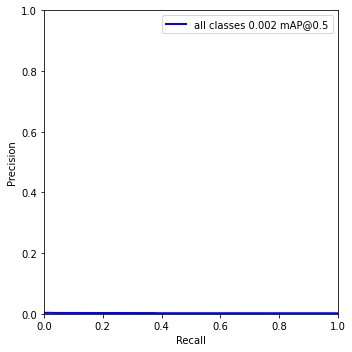

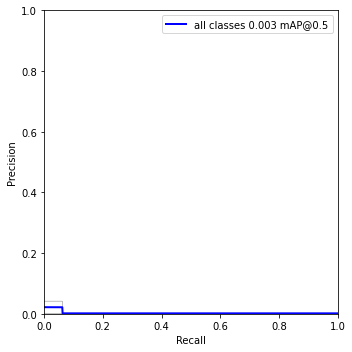

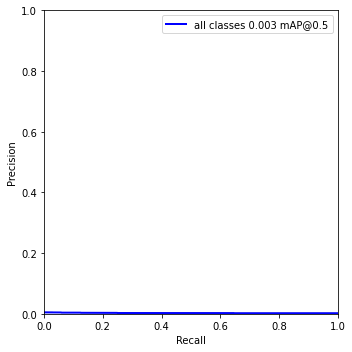

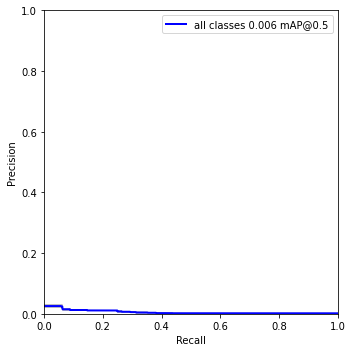

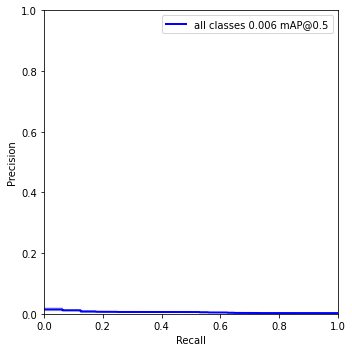

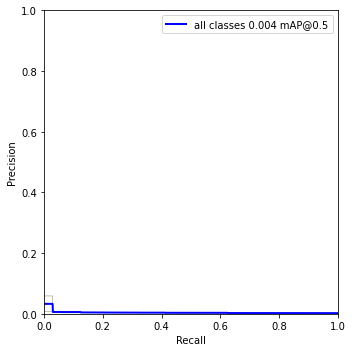

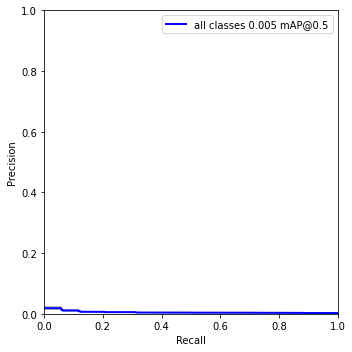

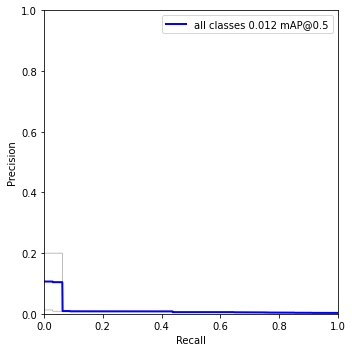

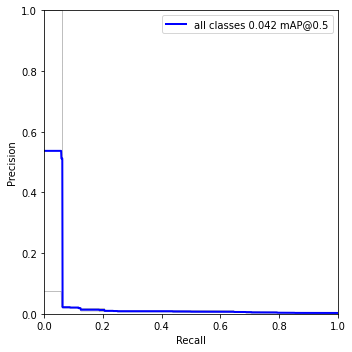

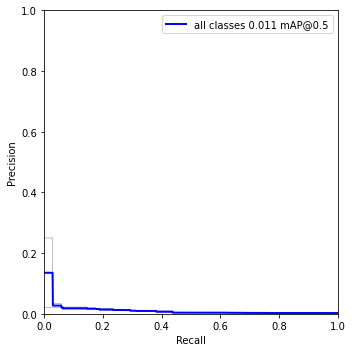

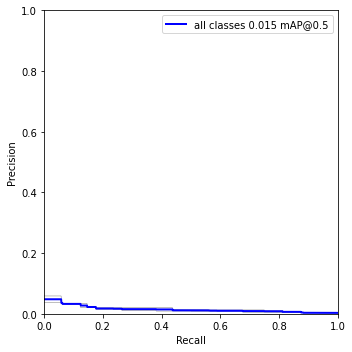

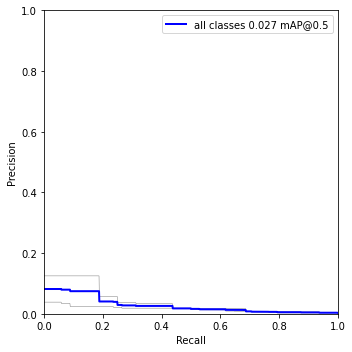

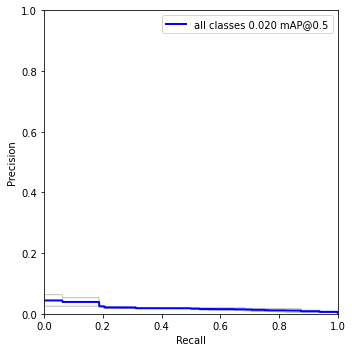

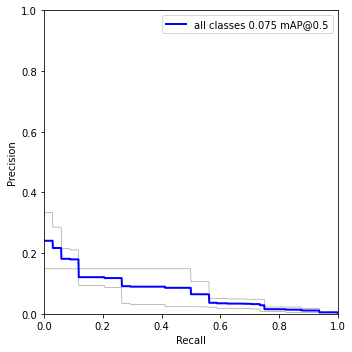

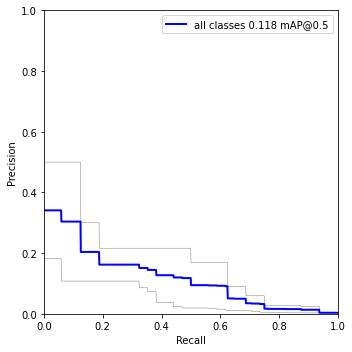

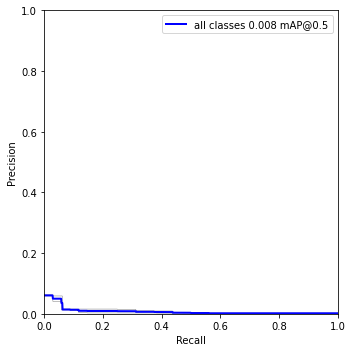

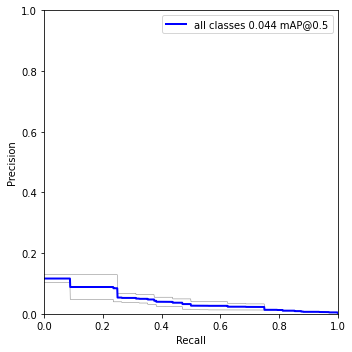

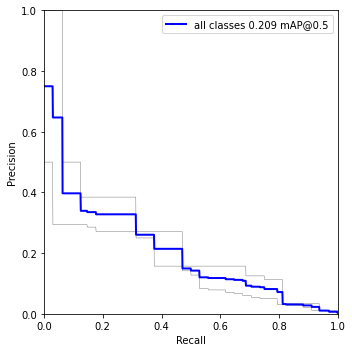

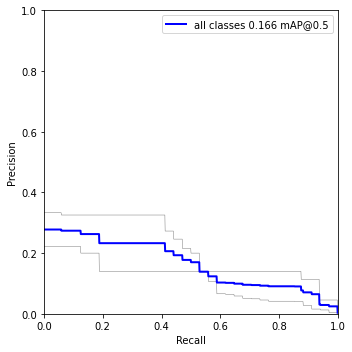

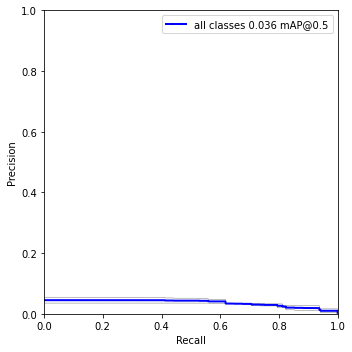

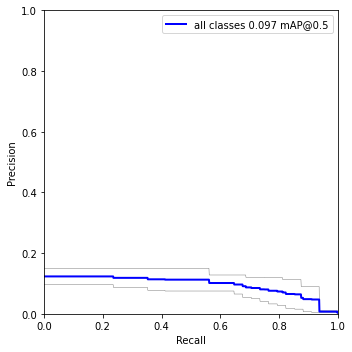

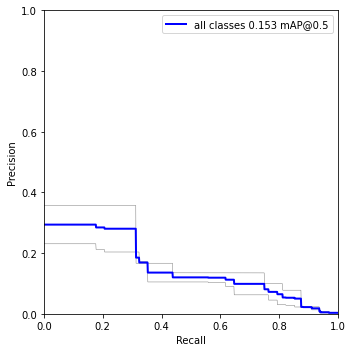

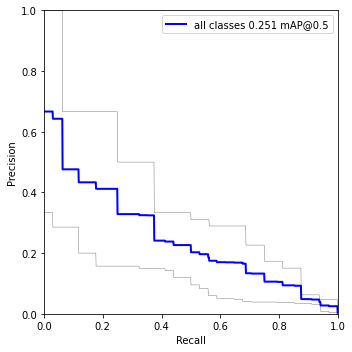

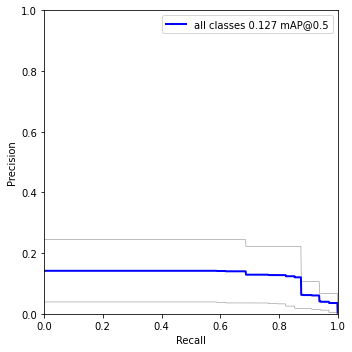

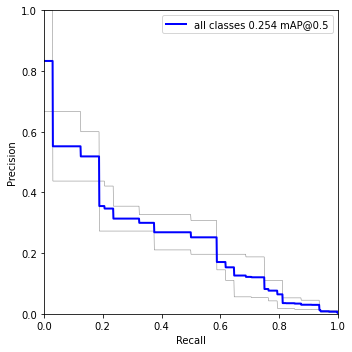

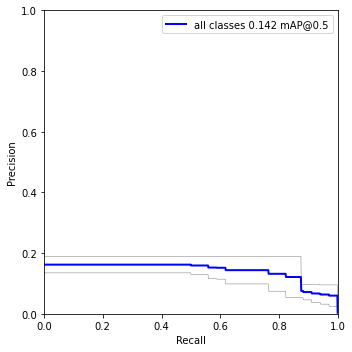

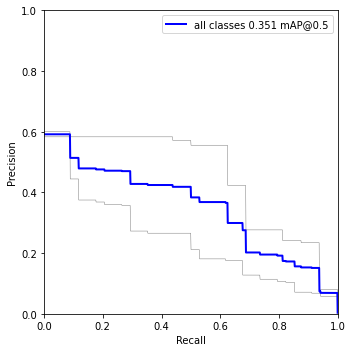

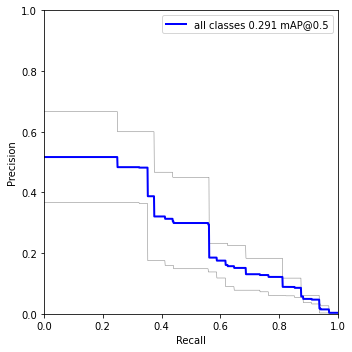

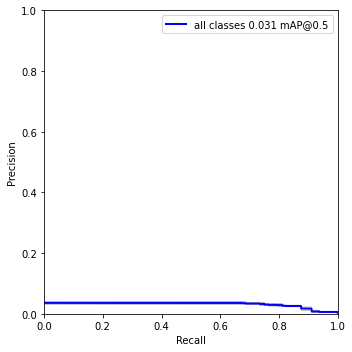

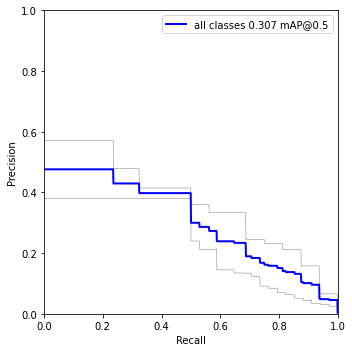

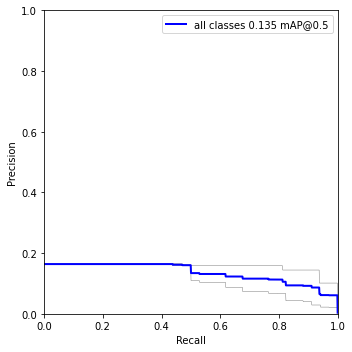

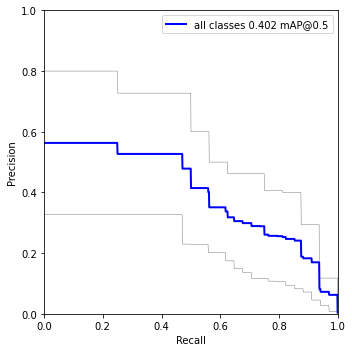

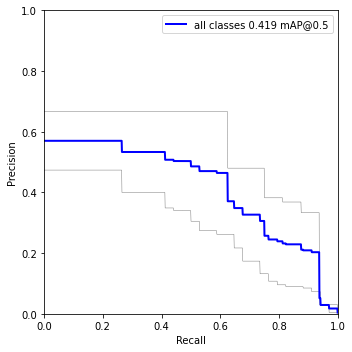

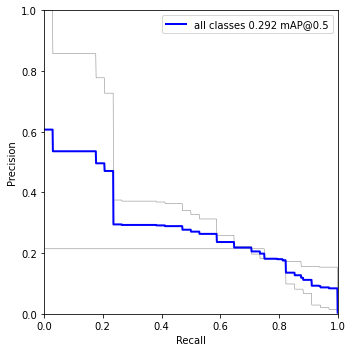

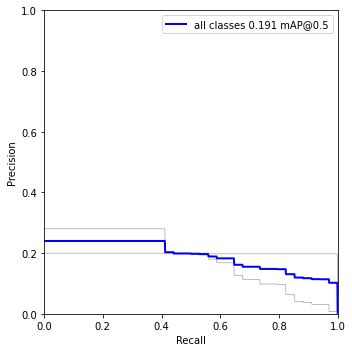

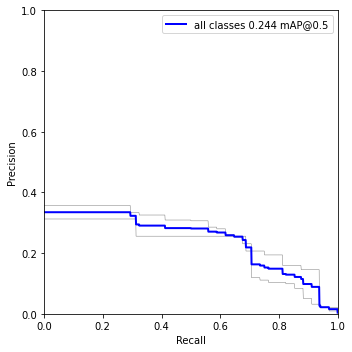

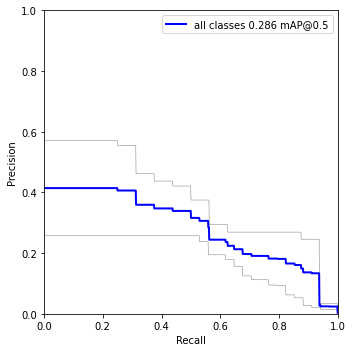

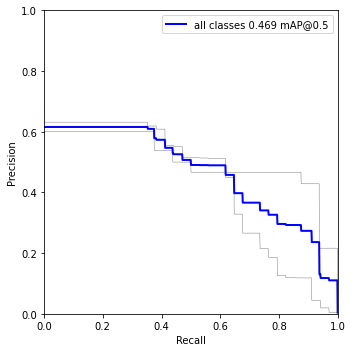

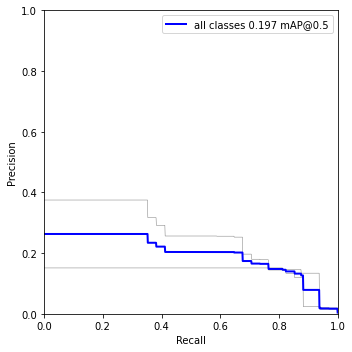

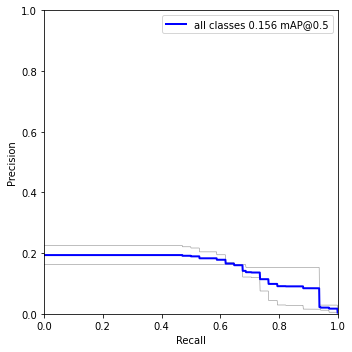

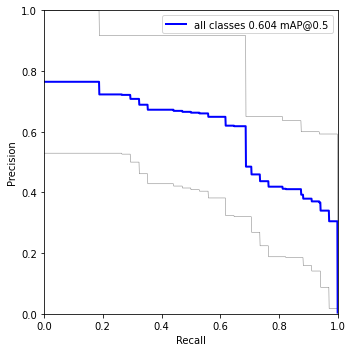

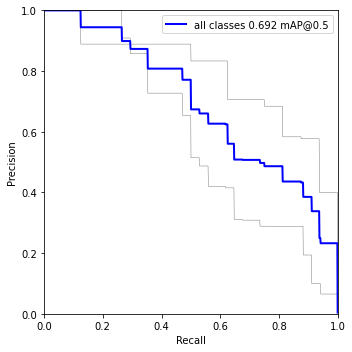

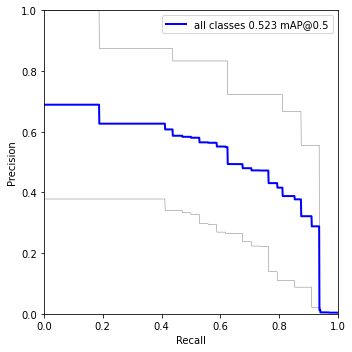

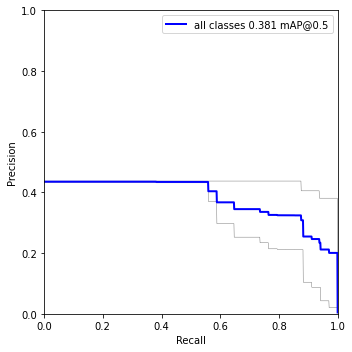

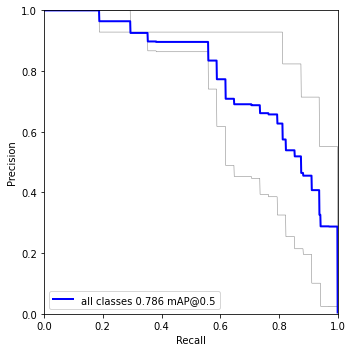

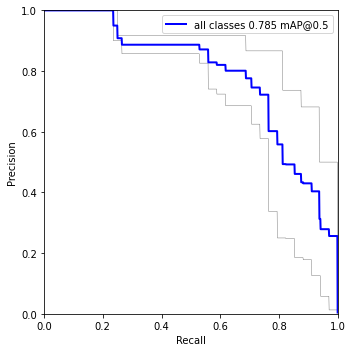

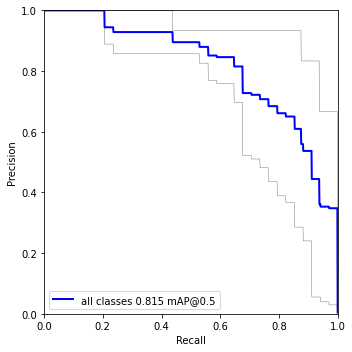

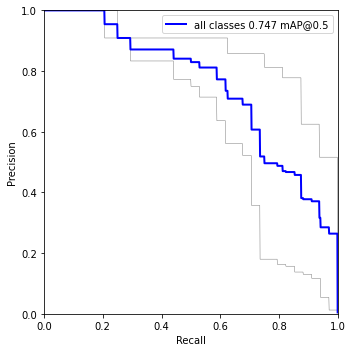

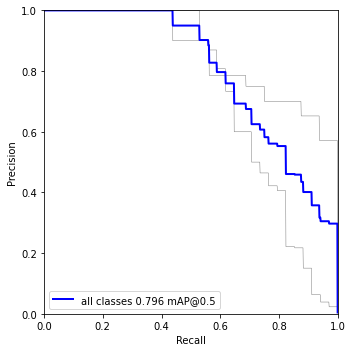

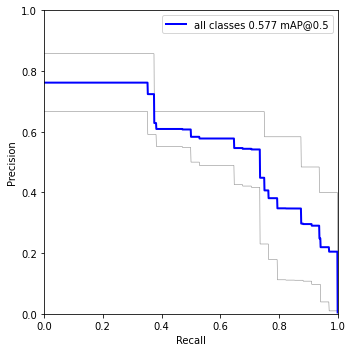

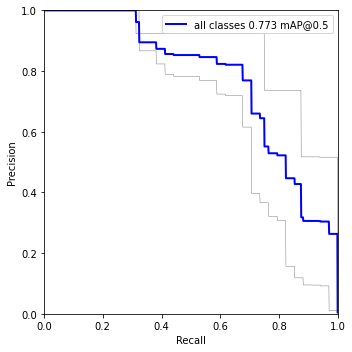

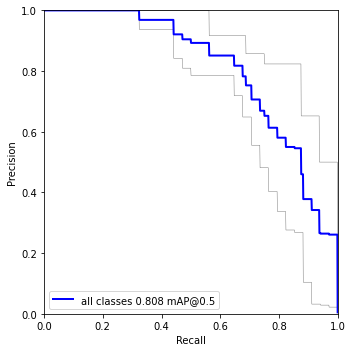

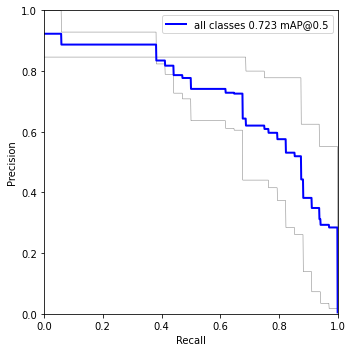

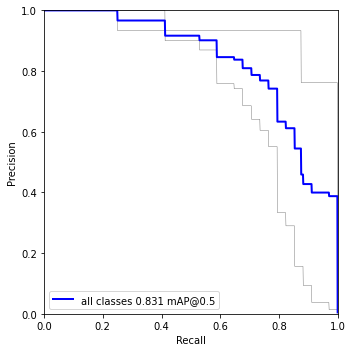

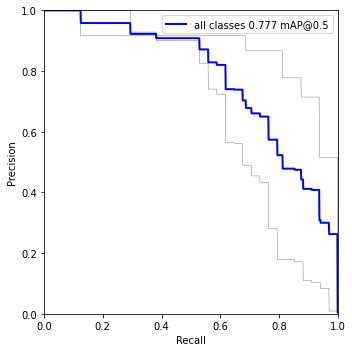

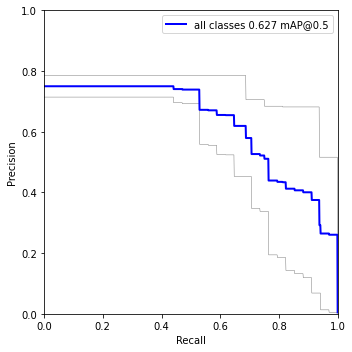

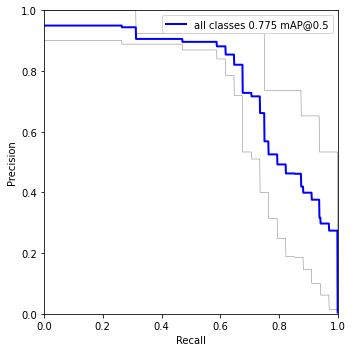

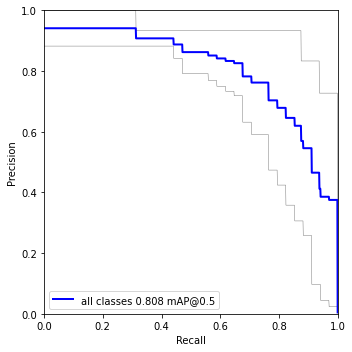

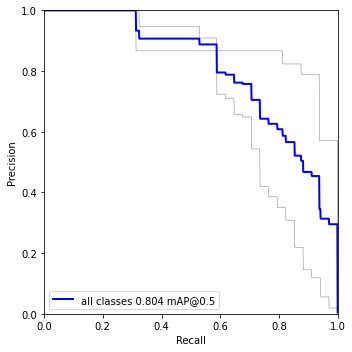

In [ ]:
# Start training
# best_fitness是以 [0.0, 0.0, 0.1, 0.9] 為係數並乘以 [precision, recall, mAP@0.5, mAP@0.5:0.95] 再求和所得
best_fitness = 0.0
results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)

scheduler.step(0)
s = ('%10s' * 5 + '%12s' * 1 + '%10s' * 2) % (
    'epoch', 'memeory', 'box_loss', 'obj_loss', 'cls_loss', 'total_loss', 'targets', 'img_size')
print(s)
for epoch in range(1, epochs+1):  # epoch ------------------------------------------------------------------
    model.train()
    mloss = torch.zeros(4, device=device)  # mean losses
    pbar = enumerate(dataloader)
    pbar = tqdm(pbar, total=nb)  # progress bar
    for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
        # 計算迭代的次數 iteration
        ni = i + nb * epoch  # number integrated batches (since train start)
        imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0    
        
        # Multi-scale
        sz = random.randrange(imgsz * 0.75, imgsz * 1.25 + gs) // gs * gs  # size
        sf = sz / max(imgs.shape[2:])  # scale factor
        if sf != 1:
            ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
            imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

        # Forward
        pred = model(imgs)  # forward
        # 計算損失，包括分類損失，objectness損失，框的迴歸損失
        # loss為總損失值，loss_items為一個元組，包含分類損失，objectness損失，框的迴歸損失和總損失
        loss, loss_items = compute_loss(pred, targets.to(device), model)  # loss scaled by batch_size

        # Backward
        loss.backward()

        # Optimize
        # 模型反向傳播 accumulate 次之後再根據累積的梯度更新一次參數
        if ni % accumulate == 0:
            optimizer.step()  # optimizer.step
            optimizer.zero_grad()
            ema.update(model)

        # Print
        # 印出進行的輪次, 記憶體佔用量, box_loss, obj_loss, cls_loss, total_loss, target 的數量, 圖片的 size
        mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
        s = ('%10s' * 2 + '%10.4g' * 3 + '%12.4g' * 1 + '%10.4g' * 2) % (
            '%g/%g' % (epoch, epochs), mem, *mloss, targets.shape[0], imgs.shape[-1])
        pbar.set_description(s)

        # Plot
        # 將前三次迭代 batch 的標籤框在圖片上畫出來並記錄到 wandb 上
        if plots and ni < 3:
            f = save_dir / f'train_batch{ni}.jpg'  # filename
            plot_images(images=imgs, targets=targets, paths=paths, fname=f)
        elif plots and ni == 3 and wandb:
            wandb.log({"Mosaics": [wandb.Image(str(x), caption=x.name) for x in save_dir.glob('train*.jpg')]})

        # end batch ------------------------------------------------------------------------------------------------
    # end epoch ----------------------------------------------------------------------------------------------------

    # Scheduler
    # 進行學習率衰減
    lr = scheduler.get_lr()  # for tensorboard
    scheduler.step()
    ema.update_attr(model)

    # 5 個 epoch 驗證一次驗證集，並計算 mAP 等指標
    if epoch%5==0:
        results, maps, times = test.test(data,
                                     batch_size=batch_size*2,
                                     imgsz=imgsz_test,
                                     model=ema.ema,
                                     dataloader=testloader,
                                     save_dir=save_dir,
                                     plots=plots,
                                     log_imgs=16)

    # Write
    # 將指標寫入 result.txt
    with open(results_file, 'a') as f:
        f.write(s + '%10.4g' * 7 % results + '\n')  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)

    # Log
    # 添加指標到 wandb 中
    tags = ['train/box_loss', 'train/obj_loss', 'train/cls_loss',  # train loss
            'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95',
            'val/box_loss', 'val/obj_loss', 'val/cls_loss',  # val loss
            'x/lr']  # params
    for x, tag in zip(list(mloss[:-1]) + list(results) + lr, tags):
        wandb.log({tag: x})  # W&B

    # Update best mAP
    fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
    if fi > best_fitness:
        best_fitness = fi

    # Save model
    with open(results_file, 'r') as f:  # create checkpoint
        ckpt = {'epoch': epoch,
                'best_fitness': best_fitness,
                'training_results': f.read(),
                'model': ema.ema.state_dict(),
                'optimizer': optimizer.state_dict(),
                'wandb_id': wandb_run.id}

    # Save best model and delete
    if best_fitness == fi:
      torch.save(ckpt, os.path.join(wandb.run.dir, 'best.pt'))
    del ckpt
    # end epoch ----------------------------------------------------------------------------------------------------
# end training

wandb.run.finish()
torch.cuda.empty_cache()

# YOLOv4 簡易訓練教學

### 匯入所需套件

In [ ]:
!pip install wandb pycocotools PyYAML==5.4.1 opencv-python==4.4.0.46 imgaug==0.2.5 -q
!git clone https://github.com/d246810g2000/PyTorch_YOLOv4.git

     |████████████████████████████████| 1.7 MB 5.5 MB/s 
     |████████████████████████████████| 636 kB 42.0 MB/s 
     |████████████████████████████████| 49.5 MB 124 kB/s 
     |████████████████████████████████| 562 kB 27.2 MB/s 
     |████████████████████████████████| 144 kB 30.2 MB/s 
     |████████████████████████████████| 181 kB 32.5 MB/s 
     |████████████████████████████████| 63 kB 820 kB/s 
Cloning into 'PyTorch_YOLOv4'...
remote: Enumerating objects: 807, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 807 (delta 62), reused 124 (delta 35), pack-reused 648
Receiving objects: 100% (807/807), 32.93 MiB | 29.76 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [ ]:
%cd /content/PyTorch_YOLOv4/

/content/PyTorch_YOLOv4


### 資料集轉換格式

In [ ]:
!unzip -q datasets/datasets.zip -d datasets/
!python convert_voc_to_yolo.py

### 創建 yaml 和 cfg 檔

In [ ]:
!echo -e 'train: datasets/pet/train/images\nval: datasets/pet/valid/images\n\nnc: 2\nnames: [cat, dog]' > data/pet.yaml
!head data/pet.yaml

train: datasets/pet/train/images
val: datasets/pet/valid/images

nc: 2
names: [cat, dog]


In [ ]:
!cp cfg/yolov4.cfg cfg/yolov4-pet.cfg
!sed -n -e 959p -e 966p -e 1046p -e 1053p -e 1133p -e 1140p cfg/yolov4-pet.cfg

filters=255
classes=80
filters=255
classes=80
filters=255
classes=80


In [ ]:
!sed -i '959s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '966s/80/2/' cfg/yolov4-pet.cfg
!sed -i '1046s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '1053s/80/2/' cfg/yolov4-pet.cfg
!sed -i '1133s/255/21/' cfg/yolov4-pet.cfg # (classes + 5)x3
!sed -i '1140s/80/2/' cfg/yolov4-pet.cfg

In [ ]:
!sed -n -e 959p -e 966p -e 1046p -e 1053p -e 1133p -e 1140p cfg/yolov4-pet.cfg

filters=21
classes=2
filters=21
classes=2
filters=21
classes=2


### 使用 wandb 記錄訓練過程
- 先進入官網登入：https://wandb.ai/site 
- 右上方頭像 -> settings -> 複製 API keys -> 填入下方輸入處

In [ ]:
import wandb
# Logging
id = wandb.util.generate_id()
wandb_run = wandb.init()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 開始訓練

In [ ]:
# command line training
!python train.py --device 0 --batch-size 4 --img-size 416 --data data/pet.yaml --cfg cfg/yolov4-pet.cfg --weights '' --name '$id' --epochs 300 --multi-scale

Using torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15109MB)

Namespace(adam=False, batch_size=4, bucket='', cache_images=False, cfg='cfg/yolov4-pet.cfg', data='data/pet.yaml', device='0', epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_imgs=16, multi_scale=True, name='2pstmt6k', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/2pstmt6k', single_cls=False, sync_bn=False, total_batch_size=4, weights='', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'lrf': 0.1, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.3, 'cls_pw': 1.0, 'obj': 0.6, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees